<a href="https://colab.research.google.com/github/dianakorka/statistical_capacity/blob/main/WTI_capacity_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/dianakorka/statistical_capacity/blob/main/WTI_capacity_index.ipynb
)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import plotly.express as px
import re
!pip install adjustText
from adjustText import adjust_text

## Reading and transforming data

2 excel files needed:
* latest data (WTI availability), 3 sheets,
* and the country groupings from Household_data_availability.



In [2]:
file_path = '/content/WTI_availability_20250804.xlsx'
dfs = pd.read_excel(file_path, sheet_name=None)

for name, df in dfs.items():
    print(f"Sheet: {name}, Shape: {df.shape}")

Sheet: MaxYear_by_country-indicator, Shape: (196, 17)
Sheet: ByIndicator, Shape: (102, 9)
Sheet: Codes, Shape: (15, 4)
Sheet: WTIData_2015-2024, Shape: (19267, 6)


In [3]:
file_path = '/content/WTI_availability_20250804.xlsx'

wti_codes = pd.read_excel(file_path, sheet_name='MaxYear_by_country-indicator', skiprows=[0])

# all we want from this data sheet is the ISO codes
wti_codes[['IsoCode', 'ShortName']].head()

,IsoCode,ShortName
0,AFG,Afghanistan
1,AGO,Angola
2,ALB,Albania
3,AND,Andorra
4,ARE,United Arab Emirates


In [4]:
# number of unique countries covered in this file
wti_codes.IsoCode.nunique()

195

In [5]:
file_path = '/content/WTI_availability_20250804.xlsx'

wti = pd.read_excel(file_path, sheet_name='WTIData_2015-2024')

wti = wti.iloc[:, :-2]


In [6]:
# this is the actual data we need for calculations

wti.head()

,RegionName,ShortName,Code,DataYear
0,Asia & Pacific,Afghanistan,i112,2015
1,Asia & Pacific,Afghanistan,i135tfb,2015
2,Asia & Pacific,Afghanistan,i271,2015
3,Asia & Pacific,Afghanistan,i271G,2015
4,Asia & Pacific,Afghanistan,i271mw,2015


In [7]:
# list of unique countries covered by the data file
wti.ShortName.nunique()

194

In [8]:
# list of indicators covered by the data file

wti.Code.unique()

array(['i112', 'i135tfb', 'i271', 'i271G', 'i271mw', 'i4213_256to2',
       'i4213_2to10', 'i4213_G10', 'i4213tfbb', 'i4214u', 'i271GA',
       'i4214l', 'i136mwi', 'i271G5_pop'], dtype=object)

Add in country groupings from a different excel file

In [9]:
file_path = '/content/Household_data_availability_Apr2025.xlsx'
wti_countries = pd.read_excel(file_path, sheet_name='Country definition')
wti_countries[['ShortName', 'LDC', 'LLDC', 'SIDS', 'WB_Income', 'OECD_member']].head()

,ShortName,LDC,LLDC,SIDS,WB_Income,OECD_member
0,Afghanistan,LDC,LLDC,NaN,Low income,NaN
1,Albania,NaN,NaN,NaN,Upper middle income,NaN
2,Algeria,NaN,NaN,NaN,Lower middle income,NaN
3,American Samoa,NaN,NaN,SIDS,Upper middle income,NaN
4,Andorra,NaN,NaN,NaN,High income,NaN


In [10]:
# we need to do some regrouping of countries
def assign_group(row):
    if row['OECD_member'] == 1:
        return 'Developed-OECD'
    elif (row['SIDS'] == 'SIDS') or (row['LDC'] == 'LDC'):
    #or (row['lldc'] == 'LLDC'):
        return 'SIDS + LDC'
    else:
        return 'Other developing and transition'

wti_countries['new_group'] = wti_countries.apply(assign_group, axis=1)

wti_countries[['ShortName', 'LDC', 'LLDC', 'SIDS', 'WB_Income', 'OECD_member', 'new_group', 'CountryType']].head()

,ShortName,LDC,LLDC,SIDS,WB_Income,OECD_member,new_group,CountryType
0,Afghanistan,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing
1,Albania,NaN,NaN,NaN,Upper middle income,NaN,Other developing and transition,Developed
2,Algeria,NaN,NaN,NaN,Lower middle income,NaN,Other developing and transition,Developing
3,American Samoa,NaN,NaN,SIDS,Upper middle income,NaN,SIDS + LDC,Developing
4,Andorra,NaN,NaN,NaN,High income,NaN,Other developing and transition,Developed


In [11]:
# so we get an idea how many countries are counted in which group
wti_countries.new_group.value_counts()

,count
new_group,
Other developing and transition,110
SIDS + LDC,88
Developed-OECD,38


In [12]:
wti_countries.CountryType.value_counts()

,count
CountryType,
Developing,172
Developed,60


## Grouping for WTI indicators

The next part gives us WTI indicators, their names and we construct their categories

In [13]:
# get definitions of indicator
file_path = '/content/WTI_availability_20250804.xlsx'
def_wti = pd.read_excel(file_path, sheet_name='ByIndicator', skiprows=[0])
def_wti.dropna(subset=['Code'], inplace=True)

In [14]:
# drop prices, we can't use this data as it is often not produced by the NSS but rather inhouse
def_wti = def_wti.loc[def_wti['Category'] != 'ICT Prices']

In [15]:
codes_to_keep= wti.Code.unique()

In [16]:
# here Category is the old pre-existent  WTI category already used previously for other pursposes (by technology)
def_wti = def_wti.loc[def_wti.Code.isin(codes_to_keep)][['Code', 'Category', 'Code description']]

In [17]:
def_wti.Category.value_counts()

,count
Category,
Fixed broadband,4
Mobile network coverage,3
Internet,2
Traffic - Internet,2
Fixed telephone network,1
Mobile cellular network,1
Mobile broadband,1


In [18]:

def_wti.sort_values(by='Code', inplace=True)
def_wti.reset_index(drop=True, inplace=True)

In [19]:
def_wti.head()

,Code,Category,Code description
0,i112,Fixed telephone network,Fixed-telephone subscriptions
1,i135tfb,Traffic - Internet,Fixed-broadband Internet traffic (exabytes)
2,i136mwi,Traffic - Internet,Mobile-broadband Internet traffic (within the ...
3,i271,Mobile cellular network,"Mobile-cellular telephone subscriptions, by po..."
4,i271G,Mobile network coverage,Percentage of the population covered by at lea...


Here I make the WTI_group categories which I will use later for more aggregate reporting

In [20]:
codes_A = ["i112", "i271", "i271mw", "i4213tfbb"]
codes_B = ["i271G", "i271G5_pop", "i271GA"]
codes_C = ["i135tfb", "i136mwi"]
codes_D = ["i4214l", "i4214u"]
codes_E = ["i4213_256to2", "i4213_2to10", "i4213_G10"]

def_wti["wti_group"] = np.select(
    [
        def_wti["Code"].isin(codes_A),
        def_wti["Code"].isin(codes_B),
        def_wti["Code"].isin(codes_C),
        def_wti["Code"].isin(codes_D),
        def_wti["Code"].isin(codes_E)
    ],
    [
        "A. Contracting_records",
        "B. Cell_tower_coverage",
        "C. Operator_traffic",
        "D. Operators_wholesale",
        "E. Contracting_fixed_broadband_speed"
    ],
    default="Other"
)

In [21]:
# here is the indicator grouping
def_wti[["Code", "Code description", "wti_group"]].sort_values(by="wti_group")

,Code,Code description,wti_group
0,i112,Fixed-telephone subscriptions,A. Contracting_records
3,i271,"Mobile-cellular telephone subscriptions, by po...",A. Contracting_records
7,i271mw,Active mobile-broadband subscriptions,A. Contracting_records
11,i4213tfbb,Fixed-broadband subscriptions,A. Contracting_records
4,i271G,Percentage of the population covered by at lea...,B. Cell_tower_coverage
5,i271G5_pop,Percentage of the population covered by at lea...,B. Cell_tower_coverage
6,i271GA,Percentage of the population covered by at lea...,B. Cell_tower_coverage
1,i135tfb,Fixed-broadband Internet traffic (exabytes),C. Operator_traffic
2,i136mwi,Mobile-broadband Internet traffic (within the ...,C. Operator_traffic
12,i4214l,"Lit/equipped international bandwidth capacity,...",D. Operators_wholesale


In [22]:
# adding the new grouping to the existing data file
wti = wti.merge(def_wti[["Code", "Code description", "wti_group"]], on="Code", how="left")

In [23]:
wti['DataYear'] = wti['DataYear'].astype('Int64')

In [24]:
wti.shape

(19267, 6)

In [25]:
# add the iso code
wti = wti.merge(wti_codes[['IsoCode', 'ShortName']], on="ShortName", how="left")

In [26]:
wti.shape

(19267, 7)

In [27]:
# add other country groups
wti = wti.merge(wti_countries[['ShortName', 'LDC', 'LLDC', 'SIDS', 'WB_Income', 'OECD_member', 'new_group', 'CountryType']], on="ShortName", how="left")
wti.shape

(19267, 14)

In [28]:
# Example of data we have by country
wti[wti.ShortName == 'Mali']

,RegionName,ShortName,Code,DataYear,Code description,wti_group,IsoCode,LDC,LLDC,SIDS,WB_Income,OECD_member,new_group,CountryType
11664,Africa,Mali,i112,2015,Fixed-telephone subscriptions,A. Contracting_records,MLI,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing
11665,Africa,Mali,i271,2015,"Mobile-cellular telephone subscriptions, by po...",A. Contracting_records,MLI,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing
11666,Africa,Mali,i271mw,2015,Active mobile-broadband subscriptions,A. Contracting_records,MLI,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing
11667,Africa,Mali,i4213tfbb,2015,Fixed-broadband subscriptions,A. Contracting_records,MLI,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing
11668,Africa,Mali,i4214l,2015,"Lit/equipped international bandwidth capacity,...",D. Operators_wholesale,MLI,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11738,Africa,Mali,i4213_256to2,2022,"Fixed broadband, 256 kbit/s to less than 2 Mbi...",E. Contracting_fixed_broadband_speed,MLI,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing
11739,Africa,Mali,i4213_2to10,2022,"Fixed broadband, 2 Mbit/s to less than 10 Mbit...",E. Contracting_fixed_broadband_speed,MLI,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing
11740,Africa,Mali,i4213_G10,2022,"Fixed broadband, equal to or above 10 Mbit/s s...",E. Contracting_fixed_broadband_speed,MLI,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing
11741,Africa,Mali,i4213tfbb,2022,Fixed-broadband subscriptions,A. Contracting_records,MLI,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing


## Barcode plot for the country profile

Detailed plot for ONE COUNTRY ONLY: data points per year and indicator.

In [29]:
# prepping my data to draw a barcode plot

years = [2020, 2021, 2022, 2023, 2024]

codes = ['i112', 'i271', 'i271mw', 'i4213tfbb', 'i271G' , 'i271G5_pop', 'i271GA', 'i136mwi',  'i135tfb','i4214l',
       'i4214u', 'i4213_256to2', 'i4213_2to10', 'i4213_G10']

new_names = ['A.i112', 'A.i271', 'A.i271mw', 'A.i4213tfbb', 'B.i271G' , 'B.i271G5_pop', 'B.i271GA', 'C.i136mwi',  'C.i135tfb','D.i4214l',
       'D.i4214u', 'E.i4213_256to2', 'E.i4213_2to10', 'E.i4213_G10']

wti_country = wti[(wti.ShortName == 'Madagascar')].pivot(index='Code', columns='DataYear', values = 'ShortName').reindex(columns=years, index=codes).notna().astype(int).reset_index()

wti_country.Code=new_names

wti_country

DataYear,Code,2020,2021,2022,2023,2024
0,A.i112,1,1,1,1,0
1,A.i271,1,1,1,1,0
2,A.i271mw,1,1,1,1,0
3,A.i4213tfbb,1,1,1,1,0
4,B.i271G,1,1,1,0,0
5,B.i271G5_pop,0,0,1,1,0
6,B.i271GA,1,1,1,1,0
7,C.i136mwi,0,1,1,1,0
8,C.i135tfb,1,1,1,1,0
9,D.i4214l,1,1,1,1,0


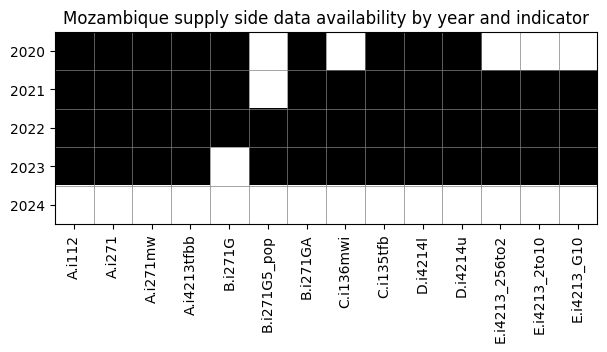

In [30]:
# Convert DataFrame to numpy array
code_array = wti_country.set_index( 'Code').T.to_numpy()

fig, ax = plt.subplots(figsize=(code_array.shape[1] * 0.5, code_array.shape[0] * 0.5))

# Show barcode
ax.imshow(code_array, cmap='binary', aspect='auto', interpolation='nearest')

# Set row labels (y-axis)
ax.set_yticks(np.arange(code_array.shape[0]))
ax.set_yticklabels(wti_country.set_index( 'Code').T.index)

# Set column labels (x-axis)
ax.set_xticks(np.arange(code_array.shape[1]))
ax.set_xticklabels(wti_country.set_index( 'Code').T.columns, rotation=90)

ax.set_title('Mozambique supply side data availability by year and indicator')

# Optional: remove grid / frame
ax.set_xticks(np.arange(-.5, code_array.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, code_array.shape[0], 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which='minor', bottom=False, left=False)

plt.show()

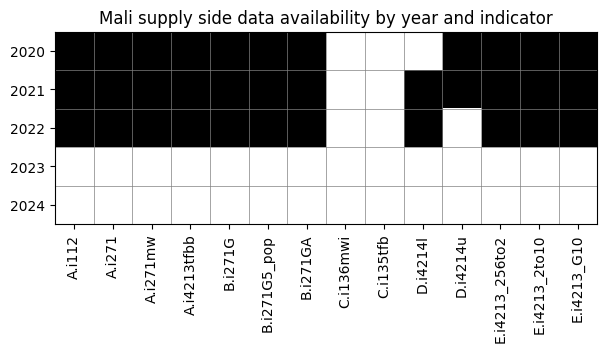

In [31]:
# prepping my data to draw a barcode plot

years = [2020, 2021, 2022, 2023, 2024]

codes = ['i112', 'i271', 'i271mw', 'i4213tfbb', 'i271G' , 'i271G5_pop', 'i271GA', 'i136mwi',  'i135tfb','i4214l',
       'i4214u', 'i4213_256to2', 'i4213_2to10', 'i4213_G10']

new_names = ['A.i112', 'A.i271', 'A.i271mw', 'A.i4213tfbb', 'B.i271G' , 'B.i271G5_pop', 'B.i271GA', 'C.i136mwi',  'C.i135tfb','D.i4214l',
       'D.i4214u', 'E.i4213_256to2', 'E.i4213_2to10', 'E.i4213_G10']

wti_country = wti[(wti.ShortName == 'Mali')].pivot(index='Code', columns='DataYear', values = 'ShortName').reindex(columns=years, index=codes).notna().astype(int).reset_index()

wti_country.Code=new_names

# Convert DataFrame to numpy array
code_array = wti_country.set_index( 'Code').T.to_numpy()

fig, ax = plt.subplots(figsize=(code_array.shape[1] * 0.5, code_array.shape[0] * 0.5))

# Show barcode
ax.imshow(code_array, cmap='binary', aspect='auto', interpolation='nearest')

ax.set_title('Mali supply side data availability by year and indicator')

# Set row labels (y-axis)
ax.set_yticks(np.arange(code_array.shape[0]))
ax.set_yticklabels(wti_country.set_index( 'Code').T.index)

# Set column labels (x-axis)
ax.set_xticks(np.arange(code_array.shape[1]))
ax.set_xticklabels(wti_country.set_index( 'Code').T.columns, rotation=90)

# Optional: remove grid / frame
ax.set_xticks(np.arange(-.5, code_array.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, code_array.shape[0], 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which='minor', bottom=False, left=False)

plt.show()

## Preparing data for calculating average availability by country-indicator

data_in_past_5_years = number of years data was available in the part 5 years for country I, indicator J. Number of times data was available in the past 5 years (2020-2024) for country I, indicator J.

5y_percent and 10y_percent = proportion years when data was available in the past 5y or 10y (2015-2024) for country I, indicator J. For example 5 years out of 5=100%, 5 years out of 10=50%.

NEED TO GROUP THE DATA BY COUNTRY-INDICATOR PAIR

In [32]:
# shows reference years initially included in the dataset

wti.DataYear.describe()

,DataYear
count,19267.0
mean,2019.579333
std,2.799148
min,2015.0
25%,2017.0
50%,2020.0
75%,2022.0
max,2024.0


In [33]:
# keep only 2020-2024 time frame for analysis

wti = wti[wti["DataYear"] >= 2020].reset_index(drop=True)


In [34]:
wti.DataYear.describe()

,DataYear
count,9940.0
mean,2021.935412
std,1.378567
min,2020.0
25%,2021.0
50%,2022.0
75%,2023.0
max,2024.0


In [35]:
# Count the number of rows per Country + Indicator
wti_counts = wti.groupby(["ShortName", "Code", "RegionName", "Code description", "wti_group", "IsoCode", "new_group", "CountryType", "WB_Income"]).size().reset_index(name="5Y")


In [36]:
wti_counts.head()

,ShortName,Code,RegionName,Code description,wti_group,IsoCode,new_group,CountryType,WB_Income,5Y
0,Afghanistan,i112,Asia & Pacific,Fixed-telephone subscriptions,A. Contracting_records,AFG,SIDS + LDC,Developing,Low income,4
1,Afghanistan,i135tfb,Asia & Pacific,Fixed-broadband Internet traffic (exabytes),C. Operator_traffic,AFG,SIDS + LDC,Developing,Low income,1
2,Afghanistan,i136mwi,Asia & Pacific,Mobile-broadband Internet traffic (within the ...,C. Operator_traffic,AFG,SIDS + LDC,Developing,Low income,3
3,Afghanistan,i271,Asia & Pacific,"Mobile-cellular telephone subscriptions, by po...",A. Contracting_records,AFG,SIDS + LDC,Developing,Low income,4
4,Afghanistan,i271G,Asia & Pacific,Percentage of the population covered by at lea...,B. Cell_tower_coverage,AFG,SIDS + LDC,Developing,Low income,4


In [37]:
wti_counts['5Y'].isna().sum()

np.int64(0)

In [38]:
# this shows there is no missing data here

wti_counts['5Y'].describe()

,5Y
count,2304.000000
mean,4.285590
std,1.151578
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [39]:
wti_counts.IsoCode.nunique()

184

In [40]:
wti_counts['5Y_p'] = wti_counts['5Y'] / 5 *100

In [41]:
# example of aggregated data output for one country
wti_counts[wti_counts.ShortName== 'Mali']

,ShortName,Code,RegionName,Code description,wti_group,IsoCode,new_group,CountryType,WB_Income,5Y,5Y_p
1291,Mali,i112,Africa,Fixed-telephone subscriptions,A. Contracting_records,MLI,SIDS + LDC,Developing,Low income,3,60.0
1292,Mali,i271,Africa,"Mobile-cellular telephone subscriptions, by po...",A. Contracting_records,MLI,SIDS + LDC,Developing,Low income,3,60.0
1293,Mali,i271G,Africa,Percentage of the population covered by at lea...,B. Cell_tower_coverage,MLI,SIDS + LDC,Developing,Low income,3,60.0
1294,Mali,i271G5_pop,Africa,Percentage of the population covered by at lea...,B. Cell_tower_coverage,MLI,SIDS + LDC,Developing,Low income,3,60.0
1295,Mali,i271GA,Africa,Percentage of the population covered by at lea...,B. Cell_tower_coverage,MLI,SIDS + LDC,Developing,Low income,3,60.0
1296,Mali,i271mw,Africa,Active mobile-broadband subscriptions,A. Contracting_records,MLI,SIDS + LDC,Developing,Low income,3,60.0
1297,Mali,i4213_256to2,Africa,"Fixed broadband, 256 kbit/s to less than 2 Mbi...",E. Contracting_fixed_broadband_speed,MLI,SIDS + LDC,Developing,Low income,3,60.0
1298,Mali,i4213_2to10,Africa,"Fixed broadband, 2 Mbit/s to less than 10 Mbit...",E. Contracting_fixed_broadband_speed,MLI,SIDS + LDC,Developing,Low income,3,60.0
1299,Mali,i4213_G10,Africa,"Fixed broadband, equal to or above 10 Mbit/s s...",E. Contracting_fixed_broadband_speed,MLI,SIDS + LDC,Developing,Low income,3,60.0
1300,Mali,i4213tfbb,Africa,Fixed-broadband subscriptions,A. Contracting_records,MLI,SIDS + LDC,Developing,Low income,3,60.0


## DOT PLOT number of countries reporting data by country group


Count how many countries have data by indicator and by country group. We take the 5 years averages calculated above.

In [42]:
# sanity check for one region: CIS countries, smallest country group
# shows there are 7 CIS countries that reported data for indicator i4214u, as in the dotplot

wti_counts[(wti_counts.RegionName=='CIS countries') & (wti_counts.Code=='i4214u')]

,ShortName,Code,RegionName,Code description,wti_group,IsoCode,new_group,CountryType,WB_Income,5Y,5Y_p
98,Armenia,i4214u,CIS countries,"International bandwidth usage, in Mbit/s",D. Operators_wholesale,ARM,Other developing and transition,Developing,Upper middle income,5,100.0
134,Azerbaijan,i4214u,CIS countries,"International bandwidth usage, in Mbit/s",D. Operators_wholesale,AZE,Other developing and transition,Developing,Upper middle income,5,100.0
199,Belarus,i4214u,CIS countries,"International bandwidth usage, in Mbit/s",D. Operators_wholesale,BLR,Other developing and transition,Developed,Upper middle income,5,100.0
1057,Kazakhstan,i4214u,CIS countries,"International bandwidth usage, in Mbit/s",D. Operators_wholesale,KAZ,Other developing and transition,Developing,Upper middle income,5,100.0
1126,Kyrgyzstan,i4214u,CIS countries,"International bandwidth usage, in Mbit/s",D. Operators_wholesale,KGZ,Other developing and transition,Developing,Lower middle income,4,80.0
2133,Turkmenistan,i4214u,CIS countries,"International bandwidth usage, in Mbit/s",D. Operators_wholesale,TKM,Other developing and transition,Developing,Upper middle income,2,40.0
2235,Uzbekistan,i4214u,CIS countries,"International bandwidth usage, in Mbit/s",D. Operators_wholesale,UZB,Other developing and transition,Developing,Lower middle income,5,100.0


In [43]:
# these are the calculations for all the regions
wti_counts[wti_counts.RegionName != 'Other Economies'].groupby(['Code', 'RegionName'])['ShortName'].nunique().reset_index(name='num_countries')


,Code,RegionName,num_countries
0,i112,Africa,40
1,i112,Arab States,21
2,i112,Asia & Pacific,36
3,i112,CIS countries,9
4,i112,Europe countries,45
...,...,...,...
79,i4214u,Arab States,19
80,i4214u,Asia & Pacific,27
81,i4214u,CIS countries,7
82,i4214u,Europe countries,18


In [44]:
import plotly.express as px


# Define custom order and colors
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'   # Orange
]

# Create a color mapping dict
color_map = dict(zip(custom_order, custom_colors))

# Your custom order and new names
codes = ['i112', 'i271', 'i271mw', 'i4213tfbb', 'i271G' , 'i271G5_pop', 'i271GA',
         'i136mwi',  'i135tfb','i4214l','i4214u', 'i4213_256to2', 'i4213_2to10', 'i4213_G10']

new_names = ['A.i112', 'A.i271', 'A.i271mw', 'A.i4213tfbb', 'B.i271G' , 'B.i271G5_pop',
             'B.i271GA', 'C.i136mwi',  'C.i135tfb','D.i4214l','D.i4214u',
             'E.i4213_256to2', 'E.i4213_2to10', 'E.i4213_G10']

# Create a mapping dict from old code to new names
rename_map = dict(zip(codes, new_names))

df = wti_counts[wti_counts.RegionName != 'Other Economies'].groupby(['Code', 'RegionName'])['ShortName'].nunique().reset_index(name='num_countries').set_index('Code').loc[codes].reset_index()
df['Code'] = df['Code'].map(rename_map)

# Create the scatter plot with custom order and colors
fig = px.scatter(
    df,
    y="Code",
    x="num_countries",
    color="RegionName",
    symbol="RegionName",
    category_orders={"RegionName": custom_order},  # enforce order
    color_discrete_map=color_map                   # enforce colors
)

# Optional: update marker size
fig.update_traces(marker_size=15)

# Remove gray background and grid lines
fig.update_layout(
    xaxis_title="Number of Countries",
    yaxis_title=" ",
    plot_bgcolor='#F5F5F5',  # white background
    paper_bgcolor='white', # white surrounding background
    xaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),  # remove x-axis grid lines
    yaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),   # remove y-axis grid lines
    legend=dict(font=dict(size=18))
)

fig.show()


In [45]:

# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']


# Your custom order and new names
codes = ['i112', 'i271', 'i271mw', 'i4213tfbb', 'i271G' , 'i271G5_pop', 'i271GA',
         'i136mwi',  'i135tfb','i4214l','i4214u', 'i4213_256to2', 'i4213_2to10', 'i4213_G10']

new_names = ['A.i112', 'A.i271', 'A.i271mw', 'A.i4213tfbb', 'B.i271G' , 'B.i271G5_pop',
             'B.i271GA', 'C.i136mwi',  'C.i135tfb','D.i4214l','D.i4214u',
             'E.i4213_256to2', 'E.i4213_2to10', 'E.i4213_G10']

# Create a mapping dict from old code to new names
rename_map = dict(zip(codes, new_names))

df = wti_counts.groupby(['Code', 'new_group'])['ShortName'].nunique().reset_index(name='num_countries').set_index('Code').loc[codes].reset_index()
df['Code'] = df['Code'].map(rename_map)

# Create the scatter plot with custom order and colors
fig = px.scatter(
    df,
    y="Code",
    x="num_countries",
    color="new_group",
    symbol="new_group",
    category_orders={"new_group": custom_order}  # enforce order
)

# Optional: update marker size
fig.update_traces(marker_size=15)

# Remove gray background and grid lines
fig.update_layout(
    xaxis_title="Number of Countries",
    yaxis_title=" ",
    plot_bgcolor='#F5F5F5',  # white background
    paper_bgcolor='white', # white surrounding background
    xaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),  # remove x-axis grid lines
    yaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),   # remove y-axis grid lines
    legend=dict(font=dict(size=18))
)

fig.show()


In [46]:

# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']


# Your custom order and new names
codes = ['i112', 'i271', 'i271mw', 'i4213tfbb', 'i271G' , 'i271G5_pop', 'i271GA',
         'i136mwi',  'i135tfb','i4214l','i4214u', 'i4213_256to2', 'i4213_2to10', 'i4213_G10']

new_names = ['A.i112', 'A.i271', 'A.i271mw', 'A.i4213tfbb', 'B.i271G' , 'B.i271G5_pop',
             'B.i271GA', 'C.i136mwi',  'C.i135tfb','D.i4214l','D.i4214u',
             'E.i4213_256to2', 'E.i4213_2to10', 'E.i4213_G10']

# Create a mapping dict from old code to new names
rename_map = dict(zip(codes, new_names))

df = wti_counts.groupby(['Code', 'WB_Income'])['ShortName'].nunique().reset_index(name='num_countries').set_index('Code').loc[codes].reset_index()
df['Code'] = df['Code'].map(rename_map)

# Create the scatter plot with custom order and colors
fig = px.scatter(
    df,
    y="Code",
    x="num_countries",
    color="WB_Income",
    symbol="WB_Income",
    category_orders={"WB_Income": custom_order}  # enforce order
)

# Optional: update marker size
fig.update_traces(marker_size=15)

# Remove gray background and grid lines
fig.update_layout(
    xaxis_title="Number of Countries",
    yaxis_title=" ",
    plot_bgcolor='#F5F5F5',  # white background
    paper_bgcolor='white', # white surrounding background
    xaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),  # remove x-axis grid lines
    yaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),   # remove y-axis grid lines
    legend=dict(font=dict(size=18))
)

fig.show()


## Availability charts (by country group)

Pivot back my data so I can plot it


Plotting everything without any assumptions about missing data.


In [47]:
pivoted = wti_counts.pivot(index=['ShortName', 'RegionName', 'IsoCode', 'new_group', 'CountryType', 'WB_Income'], columns='Code', values=['5Y', '5Y_p'])
# Replace NaNs with 0 -- OK, no longer filling NAs with 0, so no assumptions about missing data
# pivoted = pivoted.fillna(0)

# Flatten and rename the columns
pivoted.columns = [
    f"{indicator}_{suffix}"
    for suffix, indicator in pivoted.columns
]

pivoted.reset_index(inplace=True)

pivoted.head()

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,i112_5Y,i135tfb_5Y,i136mwi_5Y,i271_5Y,...,i271G_5Y_p,i271G5_pop_5Y_p,i271GA_5Y_p,i271mw_5Y_p,i4213_256to2_5Y_p,i4213_2to10_5Y_p,i4213_G10_5Y_p,i4213tfbb_5Y_p,i4214l_5Y_p,i4214u_5Y_p
0,Afghanistan,Asia & Pacific,AFG,SIDS + LDC,Developing,Low income,4.0,1.0,3.0,4.0,...,80.0,20.0,80.0,80.0,20.0,20.0,20.0,80.0,60.0,60.0
1,Albania,Europe countries,ALB,Other developing and transition,Developed,Upper middle income,5.0,5.0,5.0,5.0,...,100.0,80.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,NaN
2,Algeria,Arab States,DZA,Other developing and transition,Developing,Lower middle income,5.0,4.0,5.0,5.0,...,80.0,100.0,80.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
3,Andorra,Europe countries,AND,Other developing and transition,Developed,High income,5.0,4.0,4.0,5.0,...,100.0,80.0,100.0,100.0,80.0,60.0,80.0,100.0,80.0,80.0
4,Angola,Africa,AGO,SIDS + LDC,Developing,Lower middle income,5.0,5.0,5.0,5.0,...,100.0,40.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [48]:
pivoted.ShortName.nunique()

184

In [49]:
# add an average of all these detailed _5Y indicators so we'll be able to plot against a similar average for timeliness

pivoted['availability_5Y'] = pivoted[['i112_5Y', 'i135tfb_5Y', 'i136mwi_5Y', 'i271_5Y',
       'i271G_5Y', 'i271G5_pop_5Y', 'i271GA_5Y', 'i271mw_5Y',
       'i4213_256to2_5Y', 'i4213_2to10_5Y', 'i4213_G10_5Y', 'i4213tfbb_5Y',
       'i4214l_5Y', 'i4214u_5Y']].mean(axis=1)

pivoted['availability_5Y'].describe()

,availability_5Y
count,184.000000
mean,4.203004
std,0.999916
min,1.000000
25%,3.928571
50%,4.666667
75%,4.909091
max,5.000000


Basically for missing data no assumption is made. So we just take the average of the existing data.

In [50]:
# this code shows what happends with he missing data
pivoted[pivoted['i271G5_pop_5Y'].isna()==True].head()

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,i112_5Y,i135tfb_5Y,i136mwi_5Y,i271_5Y,...,i271G5_pop_5Y_p,i271GA_5Y_p,i271mw_5Y_p,i4213_256to2_5Y_p,i4213_2to10_5Y_p,i4213_G10_5Y_p,i4213tfbb_5Y_p,i4214l_5Y_p,i4214u_5Y_p,availability_5Y
5,Antigua and Barbuda,The Americas,ATG,SIDS + LDC,Developing,High income,1.0,NaN,NaN,1.0,...,NaN,20.0,20.0,NaN,NaN,NaN,20.0,NaN,NaN,1.000000
6,Argentina,The Americas,ARG,Other developing and transition,Developing,Upper middle income,5.0,NaN,5.0,5.0,...,NaN,100.0,60.0,100.0,100.0,100.0,100.0,NaN,NaN,4.800000
14,Barbados,The Americas,BRB,SIDS + LDC,Developing,High income,3.0,NaN,1.0,3.0,...,NaN,60.0,60.0,40.0,40.0,40.0,60.0,20.0,NaN,2.363636
19,Bolivia (Plurinational State of),The Americas,BOL,Other developing and transition,Developing,Lower middle income,5.0,1.0,1.0,3.0,...,NaN,40.0,60.0,40.0,NaN,NaN,80.0,40.0,40.0,2.545455
25,Burkina Faso,Africa,BFA,SIDS + LDC,Developing,Low income,2.0,NaN,2.0,2.0,...,NaN,40.0,40.0,40.0,40.0,40.0,40.0,40.0,20.0,1.916667


In [51]:
# this is the list of regions present in the data
pivoted.RegionName.unique()

array(['Asia & Pacific', 'Europe countries', 'Arab States', 'Africa',
       'The Americas', 'CIS countries', 'Other Economies'], dtype=object)

In [52]:
pivoted.columns

Index(['ShortName', 'RegionName', 'IsoCode', 'new_group', 'CountryType',
       'WB_Income', 'i112_5Y', 'i135tfb_5Y', 'i136mwi_5Y', 'i271_5Y',
       'i271G_5Y', 'i271G5_pop_5Y', 'i271GA_5Y', 'i271mw_5Y',
       'i4213_256to2_5Y', 'i4213_2to10_5Y', 'i4213_G10_5Y', 'i4213tfbb_5Y',
       'i4214l_5Y', 'i4214u_5Y', 'i112_5Y_p', 'i135tfb_5Y_p', 'i136mwi_5Y_p',
       'i271_5Y_p', 'i271G_5Y_p', 'i271G5_pop_5Y_p', 'i271GA_5Y_p',
       'i271mw_5Y_p', 'i4213_256to2_5Y_p', 'i4213_2to10_5Y_p',
       'i4213_G10_5Y_p', 'i4213tfbb_5Y_p', 'i4214l_5Y_p', 'i4214u_5Y_p',
       'availability_5Y'],
      dtype='object')

In [53]:
## this dataset contains imputed 0s as in 0 data point available
pivoted.i4213_2to10_5Y.describe()

,i4213_2to10_5Y
count,161.000000
mean,4.242236
std,1.182034
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [54]:
pivoted.i4213_2to10_5Y.isna().sum()

np.int64(23)

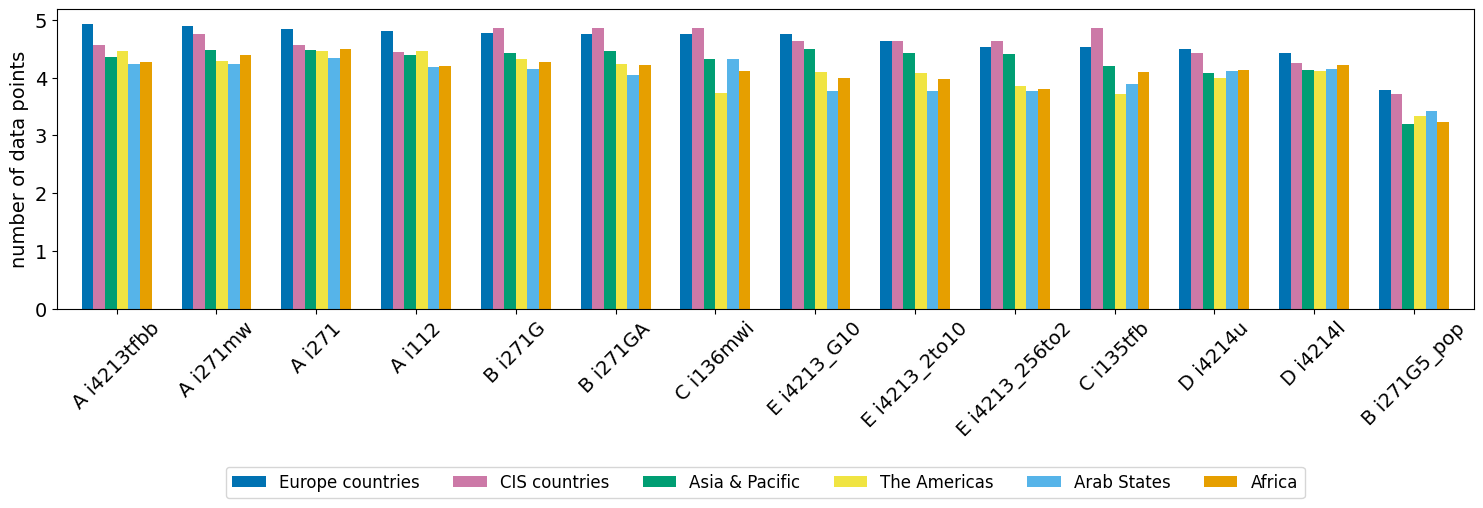

In [55]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]

rename_dict = {
 'i112_5Y': 'A i112',
 'i135tfb_5Y': 'C i135tfb',
 'i136mwi_5Y': 'C i136mwi',
 'i271_5Y': 'A i271',
 'i271G_5Y': 'B i271G',
 'i271G5_pop_5Y': 'B i271G5_pop',
 'i271GA_5Y': 'B i271GA',
 'i271mw_5Y': 'A i271mw',
 'i4213_256to2_5Y': 'E i4213_256to2',
 'i4213_2to10_5Y': 'E i4213_2to10',
 'i4213_G10_5Y': 'E i4213_G10',
 'i4213tfbb_5Y': 'A i4213tfbb',
 'i4214l_5Y': 'D i4214l',
 'i4214u_5Y': 'D i4214u'
}

pivoted[['RegionName','i112_5Y', 'i135tfb_5Y',
       'i136mwi_5Y', 'i271_5Y', 'i271G_5Y', 'i271G5_pop_5Y', 'i271GA_5Y',
       'i271mw_5Y', 'i4213_256to2_5Y', 'i4213_2to10_5Y', 'i4213_G10_5Y',
       'i4213tfbb_5Y', 'i4214l_5Y', 'i4214u_5Y']].rename(
     columns=rename_dict).groupby('RegionName').mean(numeric_only=True).reindex(custom_order).T.sort_values(by='Europe countries', ascending=False).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  color=custom_colors,
                                                  width=0.7)
#plt.title('Average number of data points per indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.5),
    ncol=7,
    fontsize=12
)

plt.tight_layout()
plt.show()

In [56]:
pivoted.WB_Income.unique()

array(['Low income', 'Upper middle income', 'Lower middle income',
       'High income'], dtype=object)

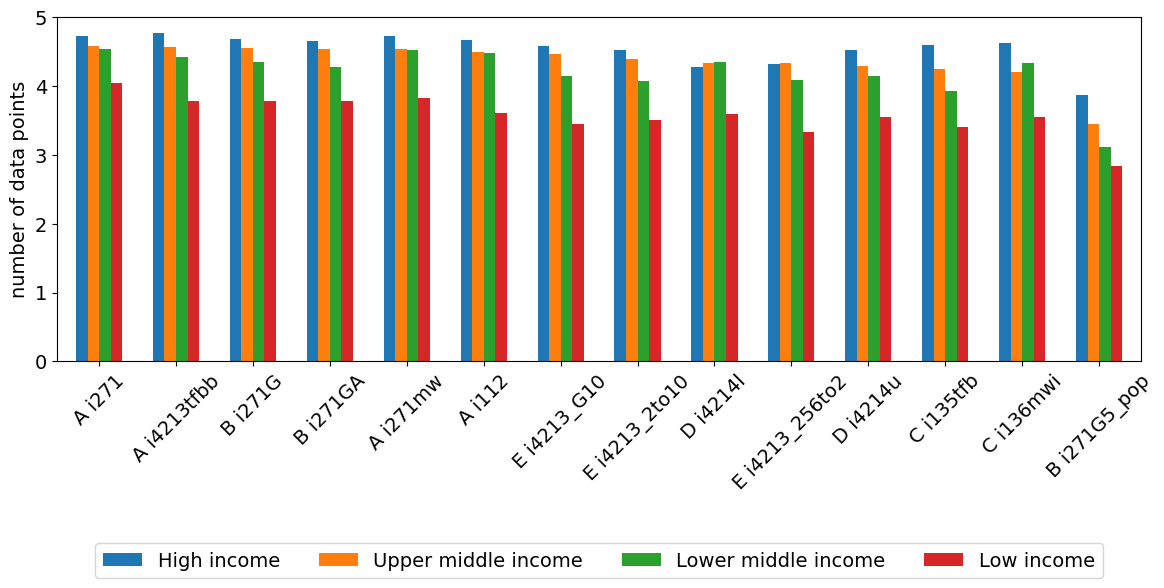

In [57]:

rename_dict = {
  'i112_5Y': 'A i112',
 'i135tfb_5Y': 'C i135tfb',
 'i136mwi_5Y': 'C i136mwi',
 'i271_5Y': 'A i271',
 'i271G_5Y': 'B i271G',
 'i271G5_pop_5Y': 'B i271G5_pop',
 'i271GA_5Y': 'B i271GA',
 'i271mw_5Y': 'A i271mw',
 'i4213_256to2_5Y': 'E i4213_256to2',
 'i4213_2to10_5Y': 'E i4213_2to10',
 'i4213_G10_5Y': 'E i4213_G10',
 'i4213tfbb_5Y': 'A i4213tfbb',
 'i4214l_5Y': 'D i4214l',
 'i4214u_5Y': 'D i4214u'
}

# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

pivoted[['WB_Income','i112_5Y', 'i135tfb_5Y',
       'i136mwi_5Y', 'i271_5Y', 'i271G_5Y', 'i271G5_pop_5Y', 'i271GA_5Y',
       'i271mw_5Y', 'i4213_256to2_5Y', 'i4213_2to10_5Y', 'i4213_G10_5Y',
       'i4213tfbb_5Y', 'i4214l_5Y', 'i4214u_5Y'
 ]].rename(columns=rename_dict).groupby('WB_Income').mean(numeric_only=True).T.sort_values(
     by='Upper middle income', ascending=False)[custom_order].plot(kind='bar',
                                                figsize=(12, 6),
                                                width=0.6)
#plt.title('Average number of data points per indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend(title='', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1) # places legend bottom

# adjust bottom margin to make space for legend
plt.subplots_adjust(bottom=0.3)  # increase bottom space

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.5),
    ncol=4,
    fontsize=14
)
plt.tight_layout()
plt.show()

In [58]:
pivoted.new_group.unique()

array(['SIDS + LDC', 'Other developing and transition', 'Developed-OECD'],
      dtype=object)

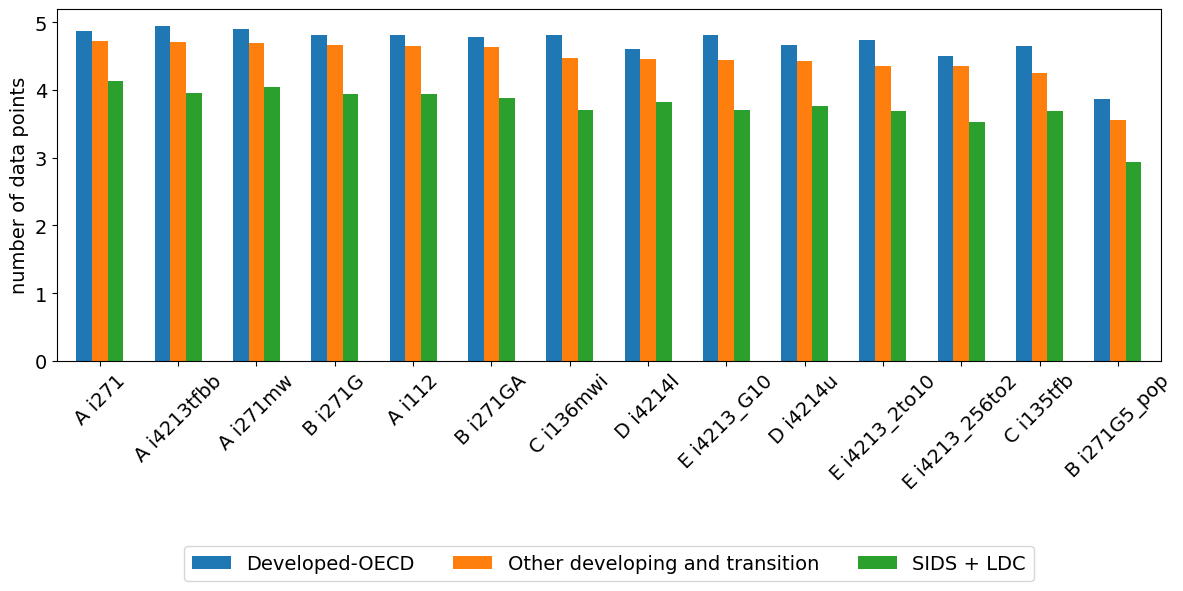

In [59]:

rename_dict = {
  'i112_5Y': 'A i112',
 'i135tfb_5Y': 'C i135tfb',
 'i136mwi_5Y': 'C i136mwi',
 'i271_5Y': 'A i271',
 'i271G_5Y': 'B i271G',
 'i271G5_pop_5Y': 'B i271G5_pop',
 'i271GA_5Y': 'B i271GA',
 'i271mw_5Y': 'A i271mw',
 'i4213_256to2_5Y': 'E i4213_256to2',
 'i4213_2to10_5Y': 'E i4213_2to10',
 'i4213_G10_5Y': 'E i4213_G10',
 'i4213tfbb_5Y': 'A i4213tfbb',
 'i4214l_5Y': 'D i4214l',
 'i4214u_5Y': 'D i4214u'
}

# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']

pivoted[['new_group','i112_5Y', 'i135tfb_5Y',
       'i136mwi_5Y', 'i271_5Y', 'i271G_5Y', 'i271G5_pop_5Y', 'i271GA_5Y',
       'i271mw_5Y', 'i4213_256to2_5Y', 'i4213_2to10_5Y', 'i4213_G10_5Y',
       'i4213tfbb_5Y', 'i4214l_5Y', 'i4214u_5Y'
 ]].rename(columns=rename_dict).groupby('new_group').mean(numeric_only=True).T.sort_values(
     by='Other developing and transition', ascending=False)[custom_order].plot(kind='bar',
                                                figsize=(12, 6),
                                                width=0.6)
#plt.title('Average number of data points per indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend(title='', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1) # places legend bottom

# adjust bottom margin to make space for legend
plt.subplots_adjust(bottom=0.3)  # increase bottom space

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.5),
    ncol=3,
    fontsize=14
)
plt.tight_layout()
plt.show()

In [60]:
pivoted.CountryType.unique()

array(['Developing', 'Developed'], dtype=object)

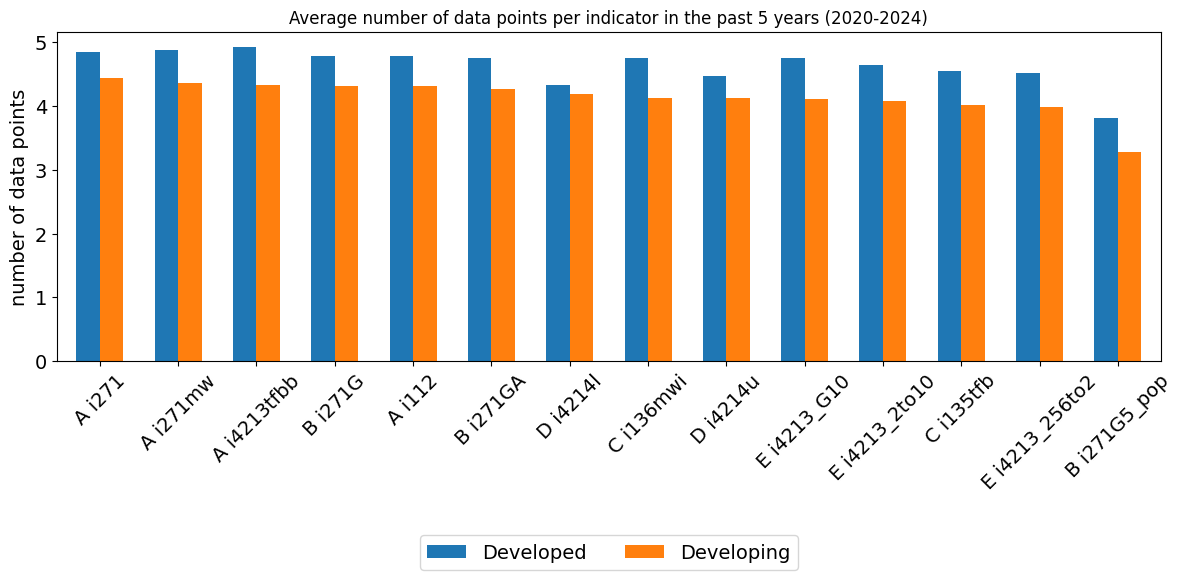

In [61]:

rename_dict = {
  'i112_5Y': 'A i112',
 'i135tfb_5Y': 'C i135tfb',
 'i136mwi_5Y': 'C i136mwi',
 'i271_5Y': 'A i271',
 'i271G_5Y': 'B i271G',
 'i271G5_pop_5Y': 'B i271G5_pop',
 'i271GA_5Y': 'B i271GA',
 'i271mw_5Y': 'A i271mw',
 'i4213_256to2_5Y': 'E i4213_256to2',
 'i4213_2to10_5Y': 'E i4213_2to10',
 'i4213_G10_5Y': 'E i4213_G10',
 'i4213tfbb_5Y': 'A i4213tfbb',
 'i4214l_5Y': 'D i4214l',
 'i4214u_5Y': 'D i4214u'
}

# Define your custom order
custom_order = [ 'Developed', 'Developing']

pivoted[['CountryType','i112_5Y', 'i135tfb_5Y',
       'i136mwi_5Y', 'i271_5Y', 'i271G_5Y', 'i271G5_pop_5Y', 'i271GA_5Y',
       'i271mw_5Y', 'i4213_256to2_5Y', 'i4213_2to10_5Y', 'i4213_G10_5Y',
       'i4213tfbb_5Y', 'i4214l_5Y', 'i4214u_5Y'
 ]].rename(columns=rename_dict).groupby('CountryType').mean(numeric_only=True).T.sort_values(
     by='Developing', ascending=False)[custom_order].plot(kind='bar',
                                                figsize=(12, 6),
                                                width=0.6)
plt.title('Average number of data points per indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend(title='', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1) # places legend bottom

# adjust bottom margin to make space for legend
plt.subplots_adjust(bottom=0.3)  # increase bottom space

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.5),
    ncol=2,
    fontsize=14
)
plt.tight_layout()
plt.show()

## Charts for country profile (one country)

In [62]:
pivoted[pivoted.ShortName=='Madagascar'][['RegionName','i112_5Y', 'i135tfb_5Y',
       'i136mwi_5Y', 'i271_5Y', 'i271G_5Y', 'i271G5_pop_5Y', 'i271GA_5Y',
       'i271mw_5Y', 'i4213_256to2_5Y', 'i4213_2to10_5Y', 'i4213_G10_5Y',
       'i4213tfbb_5Y', 'i4214l_5Y', 'i4214u_5Y']]

,RegionName,i112_5Y,i135tfb_5Y,i136mwi_5Y,i271_5Y,i271G_5Y,i271G5_pop_5Y,i271GA_5Y,i271mw_5Y,i4213_256to2_5Y,i4213_2to10_5Y,i4213_G10_5Y,i4213tfbb_5Y,i4214l_5Y,i4214u_5Y
97,Africa,4.0,4.0,3.0,4.0,3.0,2.0,4.0,4.0,3.0,3.0,3.0,4.0,4.0,4.0


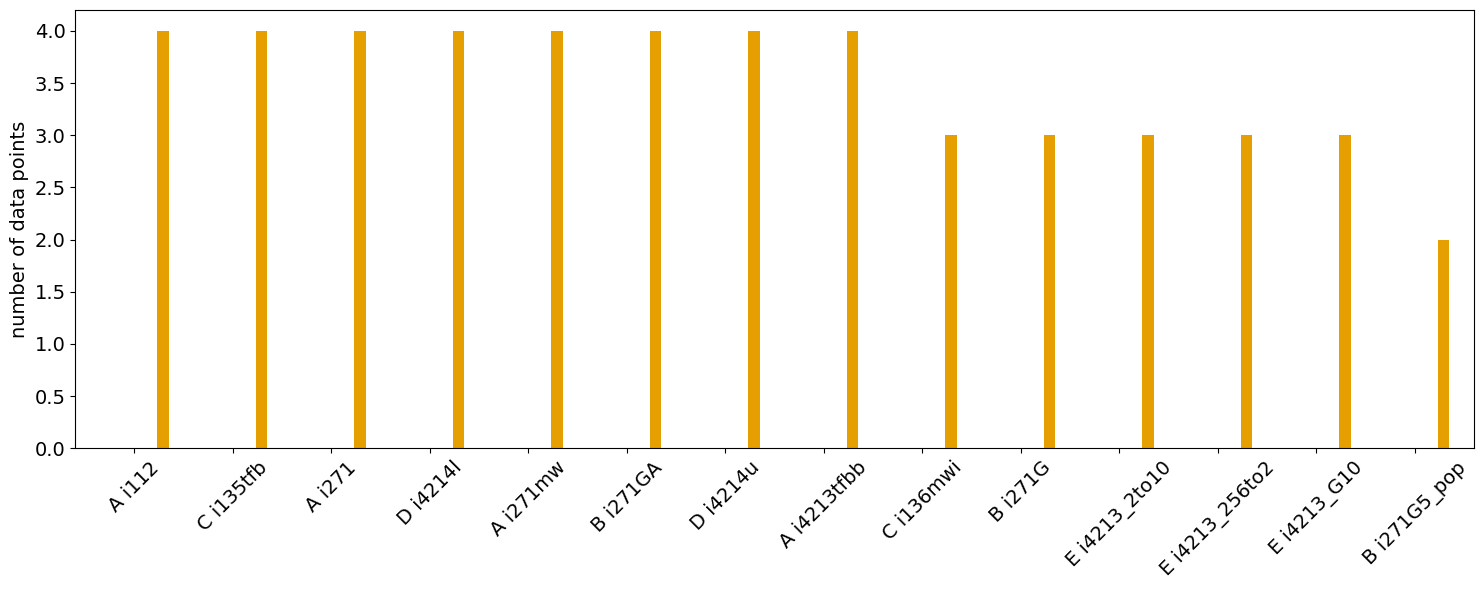

In [63]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]

rename_dict = {
 'i112_5Y': 'A i112',
 'i135tfb_5Y': 'C i135tfb',
 'i136mwi_5Y': 'C i136mwi',
 'i271_5Y': 'A i271',
 'i271G_5Y': 'B i271G',
 'i271G5_pop_5Y': 'B i271G5_pop',
 'i271GA_5Y': 'B i271GA',
 'i271mw_5Y': 'A i271mw',
 'i4213_256to2_5Y': 'E i4213_256to2',
 'i4213_2to10_5Y': 'E i4213_2to10',
 'i4213_G10_5Y': 'E i4213_G10',
 'i4213tfbb_5Y': 'A i4213tfbb',
 'i4214l_5Y': 'D i4214l',
 'i4214u_5Y': 'D i4214u'
}

pivoted[pivoted.ShortName=='Madagascar'][['RegionName','i112_5Y', 'i135tfb_5Y',
       'i136mwi_5Y', 'i271_5Y', 'i271G_5Y', 'i271G5_pop_5Y', 'i271GA_5Y',
       'i271mw_5Y', 'i4213_256to2_5Y', 'i4213_2to10_5Y', 'i4213_G10_5Y',
       'i4213tfbb_5Y', 'i4214l_5Y', 'i4214u_5Y']].rename(
     columns=rename_dict).groupby('RegionName').mean(numeric_only=True).reindex(custom_order).T.sort_values(by='Africa', ascending=False).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  color=custom_colors,
                                                  width=0.7)
#plt.title('MADAGASCAR: Average number of data points per indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
#handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
#label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
#plt.legend(
    #[label_to_handle[label] for label in custom_order],
   # custom_order,
    #loc='upper center',
    #bbox_to_anchor=(0.5, -0.5),
    #ncol=7,
   # fontsize=12
#)
plt.legend().remove()


plt.tight_layout()
plt.show()

## Group-wise calculations for availability (by group of indicators)


Within the group take the best availability - the NSS has the capacity to produce this data, but maybe it chooses not to produce all indicators because lack of policy interest

In [64]:
# Make calculations for the group of indicators - take the maximum per group

wti_counts.groupby(["ShortName", "RegionName", "wti_group", "IsoCode", 'new_group', 'CountryType', 'WB_Income'], as_index=False)["5Y"].max().head()

,ShortName,RegionName,wti_group,IsoCode,new_group,CountryType,WB_Income,5Y
0,Afghanistan,Asia & Pacific,A. Contracting_records,AFG,SIDS + LDC,Developing,Low income,4
1,Afghanistan,Asia & Pacific,B. Cell_tower_coverage,AFG,SIDS + LDC,Developing,Low income,4
2,Afghanistan,Asia & Pacific,C. Operator_traffic,AFG,SIDS + LDC,Developing,Low income,3
3,Afghanistan,Asia & Pacific,D. Operators_wholesale,AFG,SIDS + LDC,Developing,Low income,3
4,Afghanistan,Asia & Pacific,E. Contracting_fixed_broadband_speed,AFG,SIDS + LDC,Developing,Low income,1


In [65]:
wti_counts_group = wti_counts.groupby(["ShortName", "RegionName", "wti_group", "IsoCode", 'new_group', 'CountryType', 'WB_Income'], as_index=False)["5Y"].max()

# add percentage column

wti_counts_group['5Y_p'] = wti_counts_group['5Y'] / 5 *100

pivoted_group = wti_counts_group.pivot(index=['ShortName', 'RegionName', 'IsoCode', 'new_group', 'CountryType', 'WB_Income'], columns='wti_group', values=['5Y', '5Y_p'])

# Pivot back my data so I ca plot it
# Replace NaNs with 0 - rolling this back, I' no longer filling NAs with 0
#pivoted_group = pivoted_group.fillna(0)

# Flatten and rename the columns
pivoted_group.columns = [
    f"{indicator}_{suffix}"
    for suffix, indicator in pivoted_group.columns
]

pivoted_group.reset_index(inplace=True)

pivoted_group.head()

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,A. Contracting_records_5Y,B. Cell_tower_coverage_5Y,C. Operator_traffic_5Y,D. Operators_wholesale_5Y,E. Contracting_fixed_broadband_speed_5Y,A. Contracting_records_5Y_p,B. Cell_tower_coverage_5Y_p,C. Operator_traffic_5Y_p,D. Operators_wholesale_5Y_p,E. Contracting_fixed_broadband_speed_5Y_p
0,Afghanistan,Asia & Pacific,AFG,SIDS + LDC,Developing,Low income,4.0,4.0,3.0,3.0,1.0,80.0,80.0,60.0,60.0,20.0
1,Albania,Europe countries,ALB,Other developing and transition,Developed,Upper middle income,5.0,5.0,5.0,5.0,5.0,100.0,100.0,100.0,100.0,100.0
2,Algeria,Arab States,DZA,Other developing and transition,Developing,Lower middle income,5.0,5.0,5.0,5.0,5.0,100.0,100.0,100.0,100.0,100.0
3,Andorra,Europe countries,AND,Other developing and transition,Developed,High income,5.0,5.0,4.0,4.0,4.0,100.0,100.0,80.0,80.0,80.0
4,Angola,Africa,AGO,SIDS + LDC,Developing,Lower middle income,5.0,5.0,5.0,5.0,5.0,100.0,100.0,100.0,100.0,100.0


In [66]:
pivoted_group.IsoCode.nunique()

184

In [67]:
pivoted_group['E. Contracting_fixed_broadband_speed_5Y'].describe()

,E. Contracting_fixed_broadband_speed_5Y
count,168.000000
mean,4.285714
std,1.138035
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [68]:
pivoted_group.columns

Index(['ShortName', 'RegionName', 'IsoCode', 'new_group', 'CountryType',
       'WB_Income', 'A. Contracting_records_5Y', 'B. Cell_tower_coverage_5Y',
       'C. Operator_traffic_5Y', 'D. Operators_wholesale_5Y',
       'E. Contracting_fixed_broadband_speed_5Y',
       'A. Contracting_records_5Y_p', 'B. Cell_tower_coverage_5Y_p',
       'C. Operator_traffic_5Y_p', 'D. Operators_wholesale_5Y_p',
       'E. Contracting_fixed_broadband_speed_5Y_p'],
      dtype='object')

In [69]:
pivoted_group.RegionName.unique()

array(['Asia & Pacific', 'Europe countries', 'Arab States', 'Africa',
       'The Americas', 'CIS countries', 'Other Economies'], dtype=object)

In [70]:
pivoted_group[['A. Contracting_records_5Y', 'B. Cell_tower_coverage_5Y',
       'C. Operator_traffic_5Y', 'D. Operators_wholesale_5Y',
       'E. Contracting_fixed_broadband_speed_5Y']].describe()

,A. Contracting_records_5Y,B. Cell_tower_coverage_5Y,C. Operator_traffic_5Y,D. Operators_wholesale_5Y,E. Contracting_fixed_broadband_speed_5Y
count,184.000000,181.000000,167.000000,139.000000,168.000000
mean,4.586957,4.469613,4.341317,4.237410,4.285714
std,0.864000,0.957668,1.206271,1.225234,1.138035
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.000000,4.000000,4.000000,4.000000,4.000000
50%,5.000000,5.000000,5.000000,5.000000,5.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000


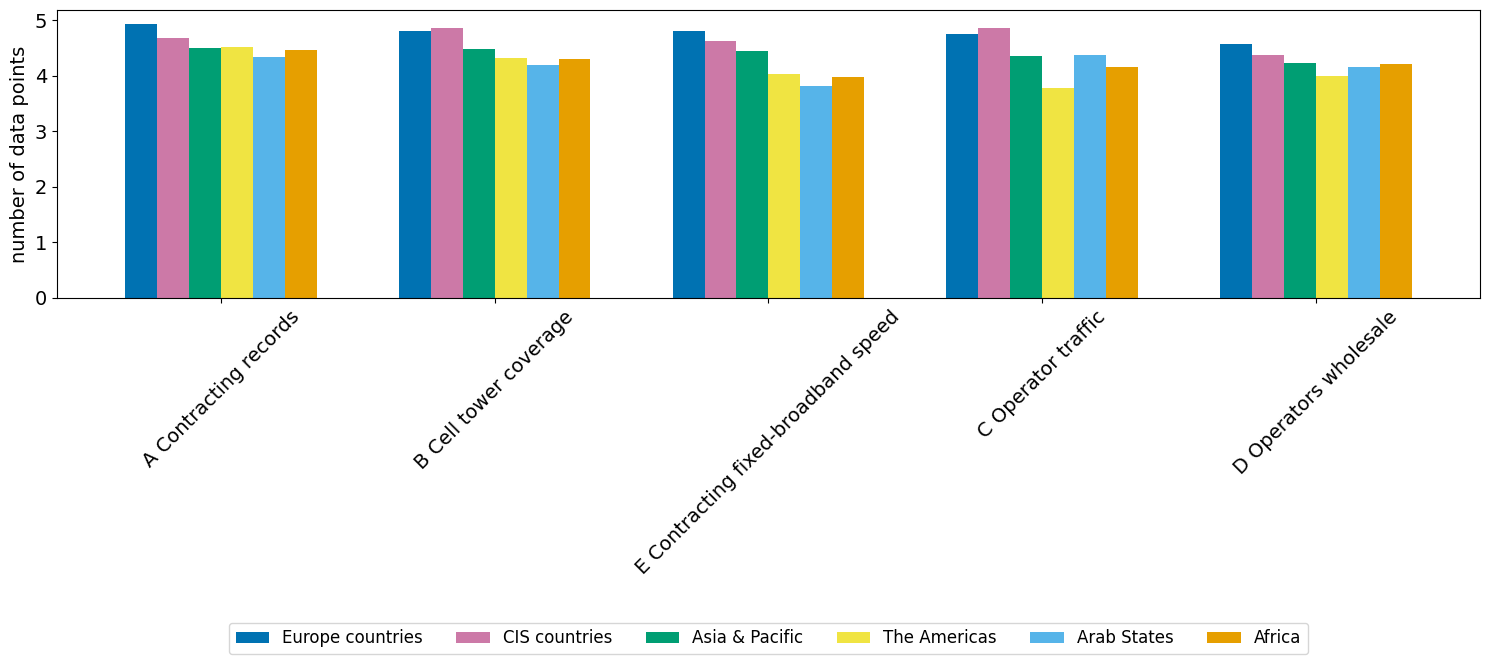

In [71]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]

rename_dict = {
'B. Cell_tower_coverage_5Y': "B Cell tower coverage",
'A. Contracting_records_5Y':"A Contracting records",
'C. Operator_traffic_5Y':"C Operator traffic",
'D. Operators_wholesale_5Y':"D Operators wholesale",
'E. Contracting_fixed_broadband_speed_5Y': "E Contracting fixed-broadband speed"
}

pivoted_group[['RegionName','B. Cell_tower_coverage_5Y',
       'A. Contracting_records_5Y', 'C. Operator_traffic_5Y',
       'D. Operators_wholesale_5Y', 'E. Contracting_fixed_broadband_speed_5Y']].rename(
     columns=rename_dict).groupby('RegionName').mean(numeric_only=True).reindex(custom_order).T.sort_values(by='Europe countries', ascending=False).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  color=custom_colors,
                                                  width=0.7)
#plt.title('Average number of data points per indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# adjust bottom margin to make space for legend
plt.subplots_adjust(bottom=0.6)  # increase bottom space

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -1.1),
    ncol=7,
    fontsize=12
)

plt.tight_layout()
plt.show()

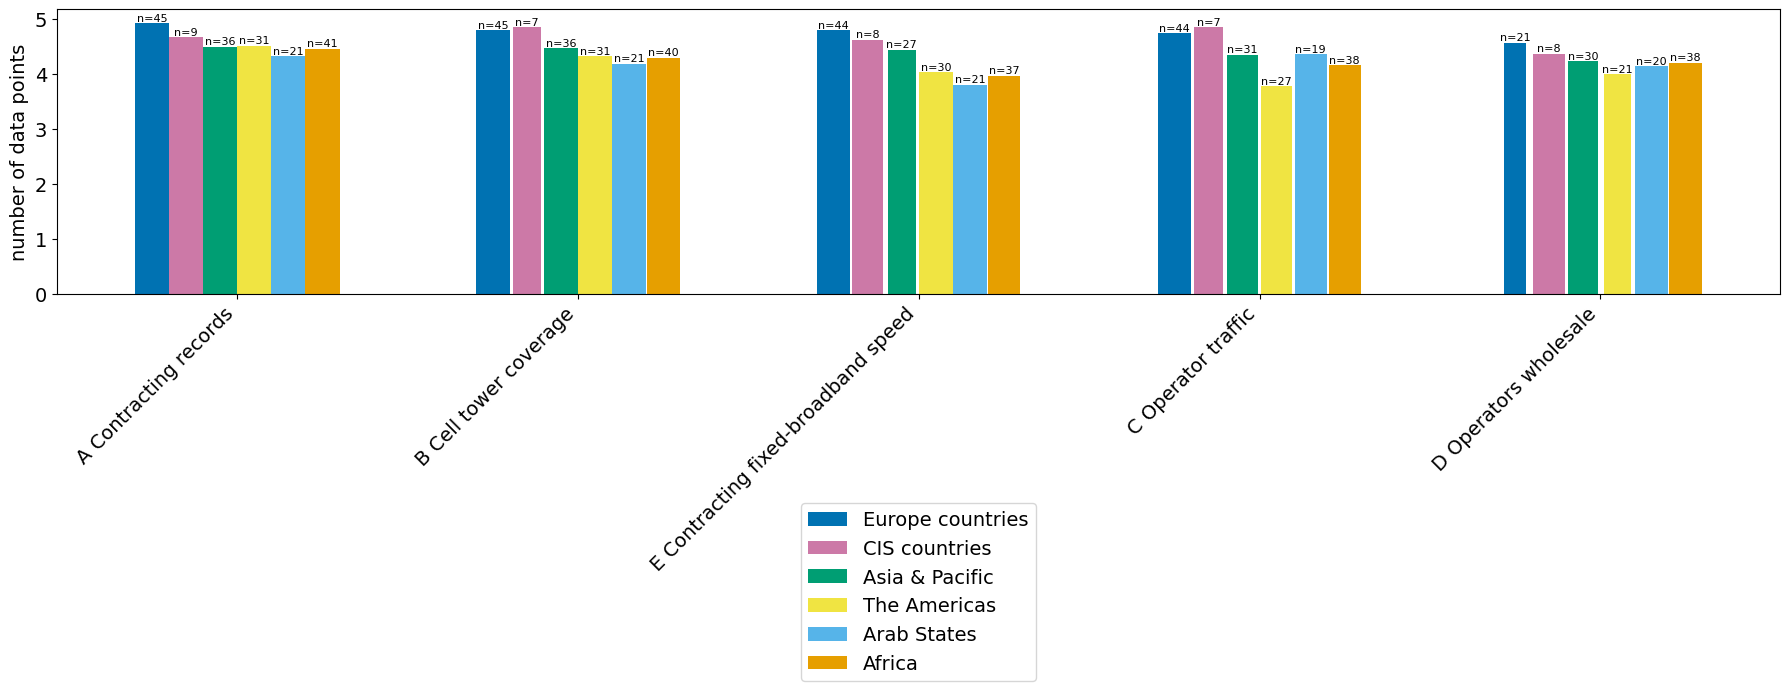

In [169]:
from matplotlib.patches import Patch

# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    ]

rename_dict = {
'B. Cell_tower_coverage_5Y': "B Cell tower coverage",
'A. Contracting_records_5Y':"A Contracting records",
'C. Operator_traffic_5Y':"C Operator traffic",
'D. Operators_wholesale_5Y':"D Operators wholesale",
'E. Contracting_fixed_broadband_speed_5Y': "E Contracting fixed-broadband speed"
}


subset = pivoted_group[['RegionName','B. Cell_tower_coverage_5Y',
       'A. Contracting_records_5Y', 'C. Operator_traffic_5Y',
       'D. Operators_wholesale_5Y', 'E. Contracting_fixed_broadband_speed_5Y']].rename(
     columns=rename_dict)

# Calculate means and counts
means = subset.groupby('RegionName').mean(numeric_only=True).T
counts = subset.groupby('RegionName').count().T

# Sort by Europe countries
means_sorted = means.sort_values(by='Europe countries', ascending=False)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(18, 6))

# Plot each region separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

for i, region in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[region].max()

    # Normalize within the group
    width_factors = counts_sorted[region] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[region].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=custom_colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[region].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=8,
                rotation=0
            )

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('number of data points', fontsize=14)
#plt.title('Timeliness in 2025: time lag of latest available data point in number of years (available data only)')
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=14, ha='right')
ax.tick_params(axis='y', labelsize=14)

# Create custom legend
legend_handles = [Patch(facecolor=custom_colors[i], label=region)
                  for i, region in enumerate(custom_order)] #

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.7),
    ncol=1,
    fontsize=14
)

plt.tight_layout()
plt.show()



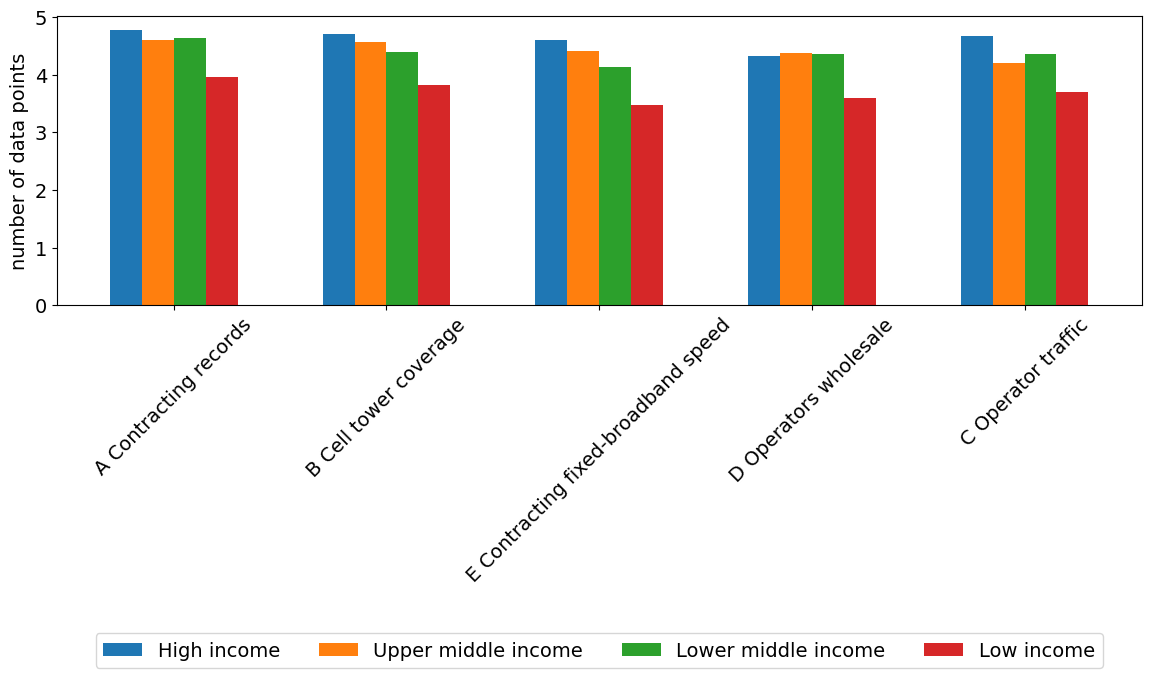

In [72]:
rename_dict = {
'B. Cell_tower_coverage_5Y': "B Cell tower coverage",
'A. Contracting_records_5Y':"A Contracting records",
'C. Operator_traffic_5Y':"C Operator traffic",
'D. Operators_wholesale_5Y':"D Operators wholesale",
'E. Contracting_fixed_broadband_speed_5Y': "E Contracting fixed-broadband speed"
}

# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

pivoted_group[['WB_Income','B. Cell_tower_coverage_5Y',
       'A. Contracting_records_5Y', 'C. Operator_traffic_5Y',
       'D. Operators_wholesale_5Y', 'E. Contracting_fixed_broadband_speed_5Y'
 ]].rename(columns=rename_dict).groupby('WB_Income').mean(numeric_only=True).T.sort_values(
     by='Upper middle income', ascending=False)[custom_order].plot(kind='bar',
                                                figsize=(12, 6),
                                                width=0.6)
#plt.title('Average number of data points per indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend(title='', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1) # places legend bottom

# adjust bottom margin to make space for legend
plt.subplots_adjust(bottom=0.7)  # increase bottom space

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -1.1),
    ncol=4,
    fontsize=14
)
plt.tight_layout()
plt.show()

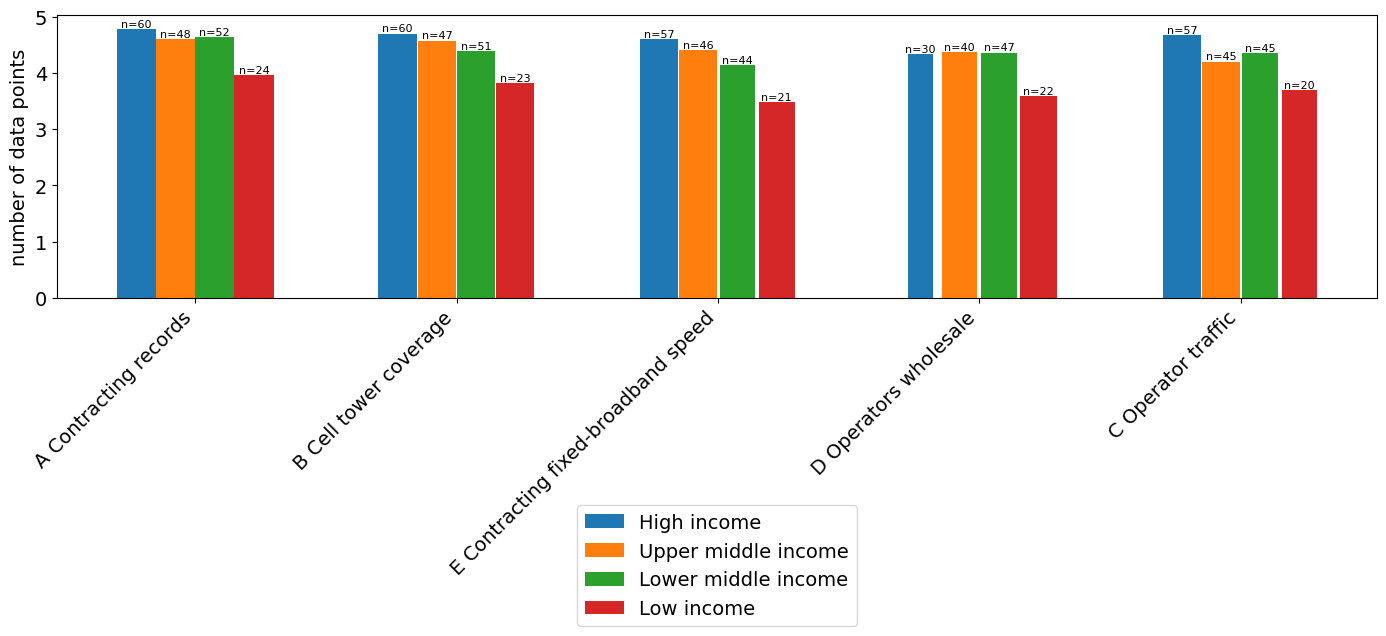

In [170]:
from matplotlib.patches import Patch

# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
#, 'Other Economies']

rename_dict = {
'B. Cell_tower_coverage_5Y': "B Cell tower coverage",
'A. Contracting_records_5Y':"A Contracting records",
'C. Operator_traffic_5Y':"C Operator traffic",
'D. Operators_wholesale_5Y':"D Operators wholesale",
'E. Contracting_fixed_broadband_speed_5Y': "E Contracting fixed-broadband speed"
}

custom_colors = ['#1f77b4',  # Blue
'#ff7f0e' , # Orange
'#2ca02c',  # Green
'#d62728'  # Red
]

subset = pivoted_group[['WB_Income','B. Cell_tower_coverage_5Y',
       'A. Contracting_records_5Y', 'C. Operator_traffic_5Y',
       'D. Operators_wholesale_5Y', 'E. Contracting_fixed_broadband_speed_5Y']].rename(
     columns=rename_dict)

# Calculate means and counts
means = subset.groupby('WB_Income').mean(numeric_only=True).T
counts = subset.groupby('WB_Income').count().T

# Sort by Europe countries
means_sorted = means.sort_values(by='Upper middle income', ascending=False)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each region separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

for i, region in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[region].max()

    # Normalize within the group
    width_factors = counts_sorted[region] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[region].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=custom_colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[region].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=8,
                rotation=0
            )

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('number of data points', fontsize=14)
#plt.title('Timeliness in 2025: time lag of latest available data point in number of years (available data only)')
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=14, ha='right')
ax.tick_params(axis='y', labelsize=14)

# Create custom legend
legend_handles = [Patch(facecolor=custom_colors[i], label=region)
                  for i, region in enumerate(custom_order)] #

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.7),
    ncol=1,
    fontsize=14
)

plt.tight_layout()
plt.show()



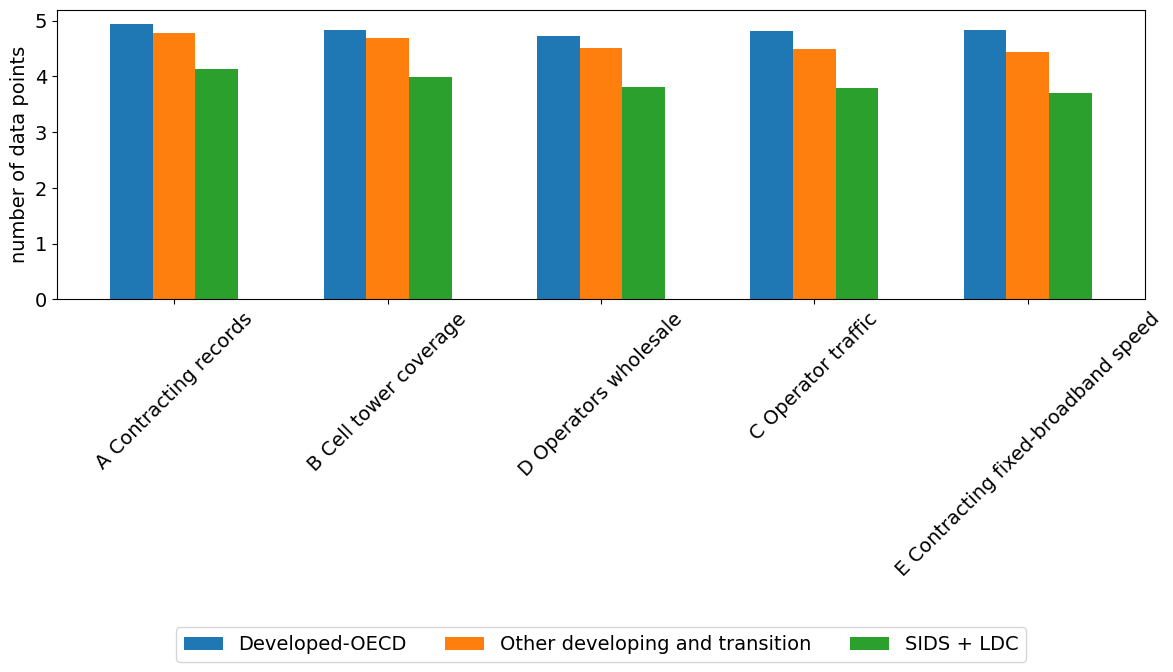

In [167]:
rename_dict = {
'B. Cell_tower_coverage_5Y': "B Cell tower coverage",
'A. Contracting_records_5Y':"A Contracting records",
'C. Operator_traffic_5Y':"C Operator traffic",
'D. Operators_wholesale_5Y':"D Operators wholesale",
'E. Contracting_fixed_broadband_speed_5Y': "E Contracting fixed-broadband speed"
}

# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']

pivoted_group[['new_group','B. Cell_tower_coverage_5Y',
       'A. Contracting_records_5Y', 'C. Operator_traffic_5Y',
       'D. Operators_wholesale_5Y', 'E. Contracting_fixed_broadband_speed_5Y'
 ]].rename(columns=rename_dict).groupby('new_group').mean(numeric_only=True).T.sort_values(
     by='Other developing and transition', ascending=False)[custom_order].plot(kind='bar',
                                                figsize=(12, 6),
                                                width=0.6)
#plt.title('Average number of data points per indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend(title='', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1) # places legend bottom

# adjust bottom margin to make space for legend
plt.subplots_adjust(bottom=0.7)  # increase bottom space

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -1.1),
    ncol=4,
    fontsize=14
)
plt.tight_layout()
plt.show()

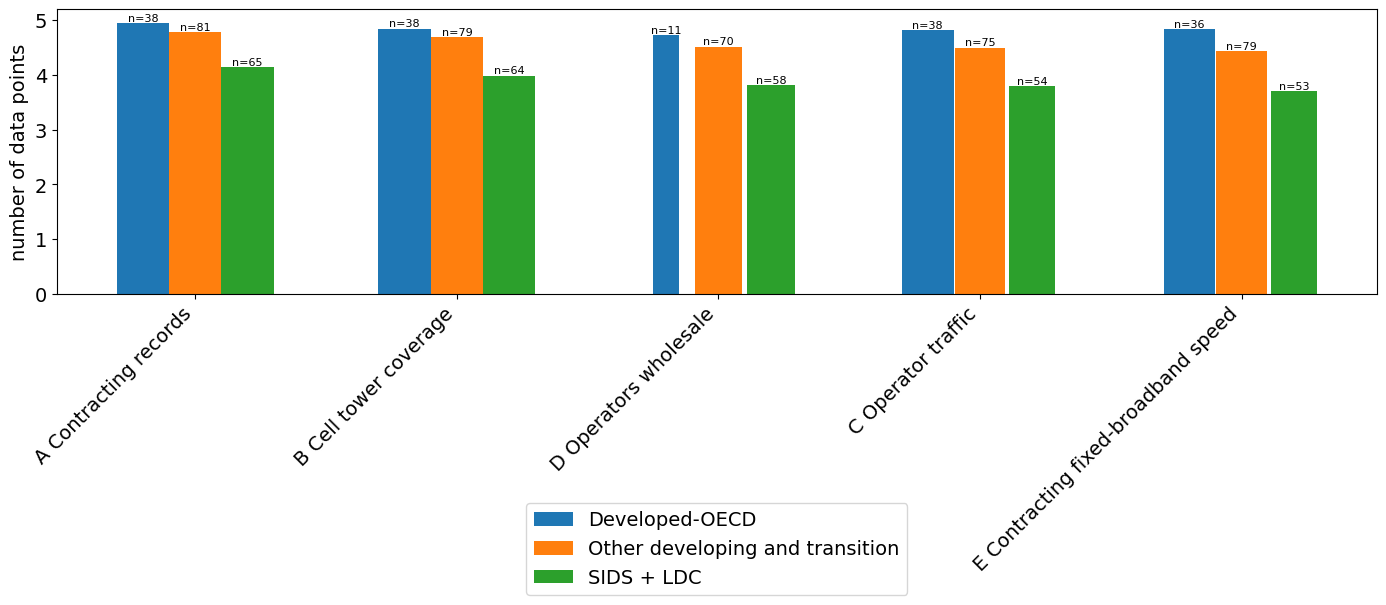

In [168]:
from matplotlib.patches import Patch

# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']

rename_dict = {
'B. Cell_tower_coverage_5Y': "B Cell tower coverage",
'A. Contracting_records_5Y':"A Contracting records",
'C. Operator_traffic_5Y':"C Operator traffic",
'D. Operators_wholesale_5Y':"D Operators wholesale",
'E. Contracting_fixed_broadband_speed_5Y': "E Contracting fixed-broadband speed"
}

custom_colors = ['#1f77b4',  # Blue
'#ff7f0e' , # Orange
'#2ca02c',  # Green
'#d62728'  # Red
]

subset = pivoted_group[['new_group','B. Cell_tower_coverage_5Y',
       'A. Contracting_records_5Y', 'C. Operator_traffic_5Y',
       'D. Operators_wholesale_5Y', 'E. Contracting_fixed_broadband_speed_5Y']].rename(
     columns=rename_dict)

# Calculate means and counts
means = subset.groupby('new_group').mean(numeric_only=True).T
counts = subset.groupby('new_group').count().T

# Sort by Europe countries
means_sorted = means.sort_values(by='Other developing and transition', ascending=False)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each region separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

for i, region in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[region].max()

    # Normalize within the group
    width_factors = counts_sorted[region] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[region].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=custom_colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[region].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=8,
                rotation=0
            )

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('number of data points', fontsize=14)
#plt.title('Timeliness in 2025: time lag of latest available data point in number of years (available data only)')
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=14, ha='right')
ax.tick_params(axis='y', labelsize=14)

# Create custom legend
legend_handles = [Patch(facecolor=custom_colors[i], label=region)
                  for i, region in enumerate(custom_order)] #

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.7),
    ncol=1,
    fontsize=14
)

plt.tight_layout()
plt.show()



## Charts for country profile (one country)

In [74]:
pivoted_group[pivoted_group.ShortName=='Madagascar'][['RegionName','B. Cell_tower_coverage_5Y',
       'A. Contracting_records_5Y', 'C. Operator_traffic_5Y',
       'D. Operators_wholesale_5Y', 'E. Contracting_fixed_broadband_speed_5Y']]

,RegionName,B. Cell_tower_coverage_5Y,A. Contracting_records_5Y,C. Operator_traffic_5Y,D. Operators_wholesale_5Y,E. Contracting_fixed_broadband_speed_5Y
97,Africa,4.0,4.0,4.0,4.0,3.0


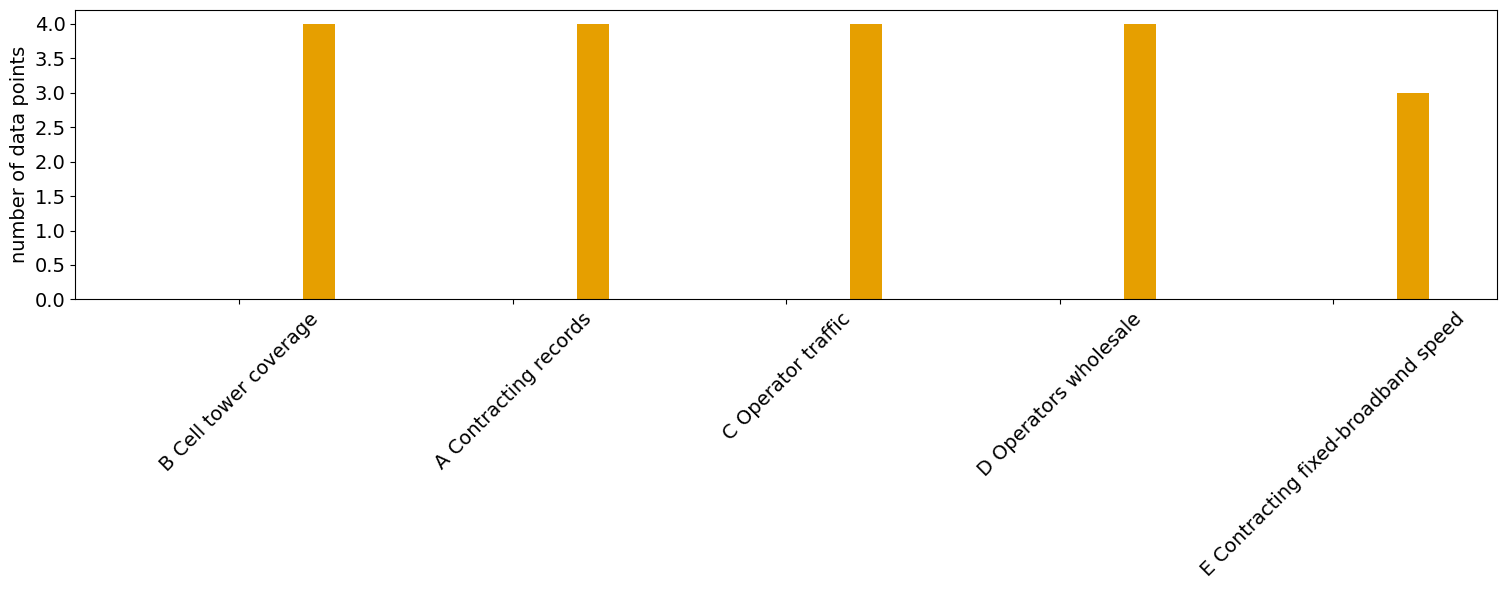

In [75]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]

rename_dict = {
'B. Cell_tower_coverage_5Y': "B Cell tower coverage",
'A. Contracting_records_5Y':"A Contracting records",
'C. Operator_traffic_5Y':"C Operator traffic",
'D. Operators_wholesale_5Y':"D Operators wholesale",
'E. Contracting_fixed_broadband_speed_5Y': "E Contracting fixed-broadband speed"
}

pivoted_group[pivoted_group.ShortName=='Madagascar'][['RegionName','B. Cell_tower_coverage_5Y',
       'A. Contracting_records_5Y', 'C. Operator_traffic_5Y',
       'D. Operators_wholesale_5Y', 'E. Contracting_fixed_broadband_speed_5Y']].rename(
     columns=rename_dict).groupby('RegionName').mean(numeric_only=True).reindex(custom_order).T.sort_values(by='Africa', ascending=False).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  color=custom_colors,
                                                  width=0.7)
#plt.title('Average number of data points per indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# adjust bottom margin to make space for legend
plt.subplots_adjust(bottom=0.6)  # increase bottom space

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -1.1),
    ncol=7,
    fontsize=12
)
plt.legend().remove()
plt.tight_layout()
plt.show()

## Timeliness

We have 2020-2024 data. we will further trim it to have only the latest year available.

For each indicator take the time lag with which data is available (with reference year 2025). Example: For country I, indicator J data was last available in 2020. Timeliness is 2025 (reference year) - 2024 (last year data available for wti1 in Austria) = 1.

Here higher values are associated with a bad performance (data is less timely if it is older).


In [76]:
# for example for Afghanistan we have a max of 4 observations per country-indicator
wti[wti.ShortName=='Afghanistan'].DataYear.unique()

<IntegerArray>
[2020, 2021, 2022, 2023]
Length: 4, dtype: Int64

In [136]:
wti[['Code', 'ShortName', 'DataYear']][(wti.ShortName=='Afghanistan') & (wti.Code=='i271G')]

,Code,ShortName,DataYear
4,i271G,Afghanistan,2020
15,i271G,Afghanistan,2021
23,i271G,Afghanistan,2022
32,i271G,Afghanistan,2023


In [77]:
wti.shape

(9940, 14)

In [78]:
wti.head()

,RegionName,ShortName,Code,DataYear,Code description,wti_group,IsoCode,LDC,LLDC,SIDS,WB_Income,OECD_member,new_group,CountryType
0,Asia & Pacific,Afghanistan,i112,2020,Fixed-telephone subscriptions,A. Contracting_records,AFG,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing
1,Asia & Pacific,Afghanistan,i135tfb,2020,Fixed-broadband Internet traffic (exabytes),C. Operator_traffic,AFG,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing
2,Asia & Pacific,Afghanistan,i136mwi,2020,Mobile-broadband Internet traffic (within the ...,C. Operator_traffic,AFG,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing
3,Asia & Pacific,Afghanistan,i271,2020,"Mobile-cellular telephone subscriptions, by po...",A. Contracting_records,AFG,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing
4,Asia & Pacific,Afghanistan,i271G,2020,Percentage of the population covered by at lea...,B. Cell_tower_coverage,AFG,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing


So we'll calculate timeliness and for each country-indicator pair we'll take the minimum.

In [79]:
wti['timeliness'] = (2025 - wti['DataYear']).astype('Int64')

In [80]:
# get min timeliness

wti_timeliness = wti.groupby(["ShortName", "Code", "RegionName", "Code description", "IsoCode", "wti_group", 'new_group', 'CountryType', 'WB_Income'], as_index=False)['timeliness'].min()
wti_timeliness.head()

,ShortName,Code,RegionName,Code description,IsoCode,wti_group,new_group,CountryType,WB_Income,timeliness
0,Afghanistan,i112,Asia & Pacific,Fixed-telephone subscriptions,AFG,A. Contracting_records,SIDS + LDC,Developing,Low income,2
1,Afghanistan,i135tfb,Asia & Pacific,Fixed-broadband Internet traffic (exabytes),AFG,C. Operator_traffic,SIDS + LDC,Developing,Low income,5
2,Afghanistan,i136mwi,Asia & Pacific,Mobile-broadband Internet traffic (within the ...,AFG,C. Operator_traffic,SIDS + LDC,Developing,Low income,2
3,Afghanistan,i271,Asia & Pacific,"Mobile-cellular telephone subscriptions, by po...",AFG,A. Contracting_records,SIDS + LDC,Developing,Low income,2
4,Afghanistan,i271G,Asia & Pacific,Percentage of the population covered by at lea...,AFG,B. Cell_tower_coverage,SIDS + LDC,Developing,Low income,2


In [81]:
# with the transformation above we get one line per country-indicator pair -- here we can see it's also the most recent one, corresponding to 2023
wti_timeliness[(wti_timeliness.ShortName=='Afghanistan') & (wti_timeliness.Code =='i112')]

,ShortName,Code,RegionName,Code description,IsoCode,wti_group,new_group,CountryType,WB_Income,timeliness
0,Afghanistan,i112,Asia & Pacific,Fixed-telephone subscriptions,AFG,A. Contracting_records,SIDS + LDC,Developing,Low income,2


In [82]:
wti_timeliness[wti_timeliness.ShortName=='Afghanistan']

,ShortName,Code,RegionName,Code description,IsoCode,wti_group,new_group,CountryType,WB_Income,timeliness
0,Afghanistan,i112,Asia & Pacific,Fixed-telephone subscriptions,AFG,A. Contracting_records,SIDS + LDC,Developing,Low income,2
1,Afghanistan,i135tfb,Asia & Pacific,Fixed-broadband Internet traffic (exabytes),AFG,C. Operator_traffic,SIDS + LDC,Developing,Low income,5
2,Afghanistan,i136mwi,Asia & Pacific,Mobile-broadband Internet traffic (within the ...,AFG,C. Operator_traffic,SIDS + LDC,Developing,Low income,2
3,Afghanistan,i271,Asia & Pacific,"Mobile-cellular telephone subscriptions, by po...",AFG,A. Contracting_records,SIDS + LDC,Developing,Low income,2
4,Afghanistan,i271G,Asia & Pacific,Percentage of the population covered by at lea...,AFG,B. Cell_tower_coverage,SIDS + LDC,Developing,Low income,2
5,Afghanistan,i271G5_pop,Asia & Pacific,Percentage of the population covered by at lea...,AFG,B. Cell_tower_coverage,SIDS + LDC,Developing,Low income,4
6,Afghanistan,i271GA,Asia & Pacific,Percentage of the population covered by at lea...,AFG,B. Cell_tower_coverage,SIDS + LDC,Developing,Low income,2
7,Afghanistan,i271mw,Asia & Pacific,Active mobile-broadband subscriptions,AFG,A. Contracting_records,SIDS + LDC,Developing,Low income,2
8,Afghanistan,i4213_256to2,Asia & Pacific,"Fixed broadband, 256 kbit/s to less than 2 Mbi...",AFG,E. Contracting_fixed_broadband_speed,SIDS + LDC,Developing,Low income,5
9,Afghanistan,i4213_2to10,Asia & Pacific,"Fixed broadband, 2 Mbit/s to less than 10 Mbit...",AFG,E. Contracting_fixed_broadband_speed,SIDS + LDC,Developing,Low income,5


In [83]:
wti.timeliness.describe()

,timeliness
count,9940.0
mean,3.064588
std,1.378567
min,1.0
25%,2.0
50%,3.0
75%,4.0
max,5.0


Here we transform the data so there is one timeliness value per country-indicator pair. This data contains NaNs

In [85]:
pivoted_t = wti_timeliness.pivot(index=['ShortName', 'RegionName', 'IsoCode', 'new_group', 'CountryType', 'WB_Income'], columns='Code', values=['timeliness'])
# Replace NaNs with 5 because max value for available data is 2024-2020 =4
#pivoted_t = pivoted_t.fillna(5)

# Flatten and rename the columns
pivoted_t.columns = [
    f"{indicator}_{suffix}"
    for suffix, indicator in pivoted_t.columns
]

pivoted_t.reset_index(inplace=True)

pivoted_t.head()

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,i112_timeliness,i135tfb_timeliness,i136mwi_timeliness,i271_timeliness,i271G_timeliness,i271G5_pop_timeliness,i271GA_timeliness,i271mw_timeliness,i4213_256to2_timeliness,i4213_2to10_timeliness,i4213_G10_timeliness,i4213tfbb_timeliness,i4214l_timeliness,i4214u_timeliness
0,Afghanistan,Asia & Pacific,AFG,SIDS + LDC,Developing,Low income,2.0,5.0,2.0,2.0,2.0,4.0,2.0,2.0,5.0,5.0,5.0,2.0,2.0,2.0
1,Albania,Europe countries,ALB,Other developing and transition,Developed,Upper middle income,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2,Algeria,Arab States,DZA,Other developing and transition,Developing,Lower middle income,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,Andorra,Europe countries,AND,Other developing and transition,Developed,High income,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
4,Angola,Africa,AGO,SIDS + LDC,Developing,Lower middle income,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [86]:
pivoted_t.ShortName.nunique()

184

In [87]:
# add a single average indicator of timeliness so we can plot it against availability

pivoted_t['timeliness'] = pivoted_t[['i112_timeliness', 'i135tfb_timeliness',
       'i136mwi_timeliness', 'i271_timeliness', 'i271G_timeliness',
       'i271G5_pop_timeliness', 'i271GA_timeliness', 'i271mw_timeliness',
       'i4213_256to2_timeliness', 'i4213_2to10_timeliness',
       'i4213_G10_timeliness', 'i4213tfbb_timeliness', 'i4214l_timeliness',
       'i4214u_timeliness']].mean(axis=1)

pivoted_t['timeliness'].describe()

,timeliness
count,184.000000
mean,1.511039
std,0.830888
min,1.000000
25%,1.000000
50%,1.071429
75%,1.637987
max,5.000000


In [88]:
# just out of curiosity checking which were these least timely countries
pivoted_t[pivoted_t.timeliness==5]

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,i112_timeliness,i135tfb_timeliness,i136mwi_timeliness,i271_timeliness,...,i271G5_pop_timeliness,i271GA_timeliness,i271mw_timeliness,i4213_256to2_timeliness,i4213_2to10_timeliness,i4213_G10_timeliness,i4213tfbb_timeliness,i4214l_timeliness,i4214u_timeliness,timeliness
5,Antigua and Barbuda,The Americas,ATG,SIDS + LDC,Developing,High income,5.0,NaN,NaN,5.0,...,NaN,5.0,5.0,NaN,NaN,NaN,5.0,NaN,NaN,5.0
89,Lebanon,Arab States,LBN,Other developing and transition,Developing,Lower middle income,5.0,5.0,5.0,5.0,...,NaN,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [89]:
pivoted_t.columns

Index(['ShortName', 'RegionName', 'IsoCode', 'new_group', 'CountryType',
       'WB_Income', 'i112_timeliness', 'i135tfb_timeliness',
       'i136mwi_timeliness', 'i271_timeliness', 'i271G_timeliness',
       'i271G5_pop_timeliness', 'i271GA_timeliness', 'i271mw_timeliness',
       'i4213_256to2_timeliness', 'i4213_2to10_timeliness',
       'i4213_G10_timeliness', 'i4213tfbb_timeliness', 'i4214l_timeliness',
       'i4214u_timeliness', 'timeliness'],
      dtype='object')

In [90]:
pivoted_t.i4213_256to2_timeliness.describe()

,i4213_256to2_timeliness
count,162.000000
mean,1.549383
std,0.959118
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,5.000000


In [91]:
pivoted_t[pivoted_t.ShortName == 'Chile']

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,i112_timeliness,i135tfb_timeliness,i136mwi_timeliness,i271_timeliness,...,i271G5_pop_timeliness,i271GA_timeliness,i271mw_timeliness,i4213_256to2_timeliness,i4213_2to10_timeliness,i4213_G10_timeliness,i4213tfbb_timeliness,i4214l_timeliness,i4214u_timeliness,timeliness
32,Chile,The Americas,CHL,Developed-OECD,Developing,High income,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0


In [92]:
wti.wti_group.unique()

array(['A. Contracting_records', 'C. Operator_traffic',
       'B. Cell_tower_coverage', 'E. Contracting_fixed_broadband_speed',
       'D. Operators_wholesale'], dtype=object)

In [93]:
wti[(wti.ShortName=='Chile')& (wti.wti_group=='D. Operators_wholesale') ]

,RegionName,ShortName,Code,DataYear,Code description,wti_group,IsoCode,LDC,LLDC,SIDS,WB_Income,OECD_member,new_group,CountryType,timeliness
1625,The Americas,Chile,i4214u,2020,"International bandwidth usage, in Mbit/s",D. Operators_wholesale,CHL,NaN,NaN,NaN,High income,1.0,Developed-OECD,Developing,5
1637,The Americas,Chile,i4214u,2021,"International bandwidth usage, in Mbit/s",D. Operators_wholesale,CHL,NaN,NaN,NaN,High income,1.0,Developed-OECD,Developing,4
1650,The Americas,Chile,i4214u,2022,"International bandwidth usage, in Mbit/s",D. Operators_wholesale,CHL,NaN,NaN,NaN,High income,1.0,Developed-OECD,Developing,3
1663,The Americas,Chile,i4214u,2023,"International bandwidth usage, in Mbit/s",D. Operators_wholesale,CHL,NaN,NaN,NaN,High income,1.0,Developed-OECD,Developing,2
1676,The Americas,Chile,i4214u,2024,"International bandwidth usage, in Mbit/s",D. Operators_wholesale,CHL,NaN,NaN,NaN,High income,1.0,Developed-OECD,Developing,1


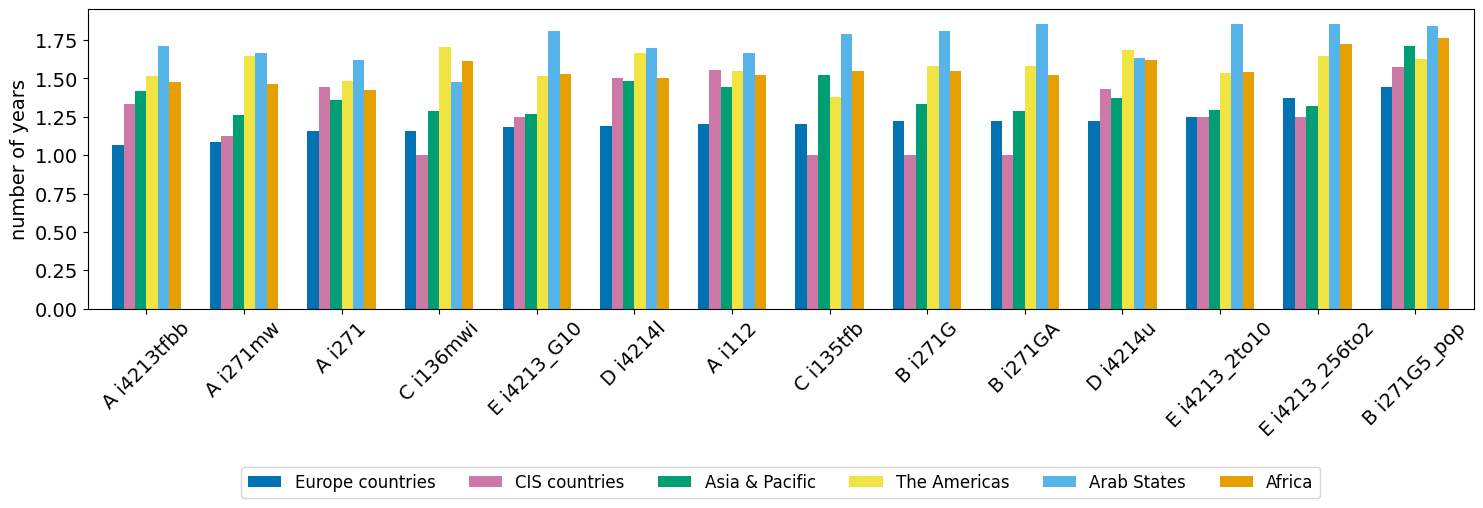

In [94]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]

rename_dict = {
 'i112_timeliness': 'A i112',
 'i135tfb_timeliness': 'C i135tfb',
 'i136mwi_timeliness': 'C i136mwi',
 'i271_timeliness': 'A i271',
 'i271G_timeliness': 'B i271G',
 'i271G5_pop_timeliness': 'B i271G5_pop',
 'i271GA_timeliness': 'B i271GA',
 'i271mw_timeliness': 'A i271mw',
 'i4213_256to2_timeliness': 'E i4213_256to2',
 'i4213_2to10_timeliness': 'E i4213_2to10',
 'i4213_G10_timeliness': 'E i4213_G10',
 'i4213tfbb_timeliness': 'A i4213tfbb',
 'i4214l_timeliness': 'D i4214l',
 'i4214u_timeliness': 'D i4214u'
}

pivoted_t[['RegionName','i112_timeliness',
       'i135tfb_timeliness', 'i136mwi_timeliness', 'i271_timeliness',
       'i271G_timeliness', 'i271G5_pop_timeliness', 'i271GA_timeliness',
       'i271mw_timeliness', 'i4213_256to2_timeliness',
       'i4213_2to10_timeliness', 'i4213_G10_timeliness',
       'i4213tfbb_timeliness', 'i4214l_timeliness', 'i4214u_timeliness']].rename(
     columns=rename_dict).groupby('RegionName').mean(numeric_only=True).reindex(custom_order).T.sort_values(by='Europe countries', ascending=True).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  color=custom_colors,
                                                  width=0.7)
#plt.title('Timeliness in 2024: time lag of latest available data point in number of years (available data only)')
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.5),
    ncol=7,
    fontsize=12
)

plt.tight_layout()
plt.show()

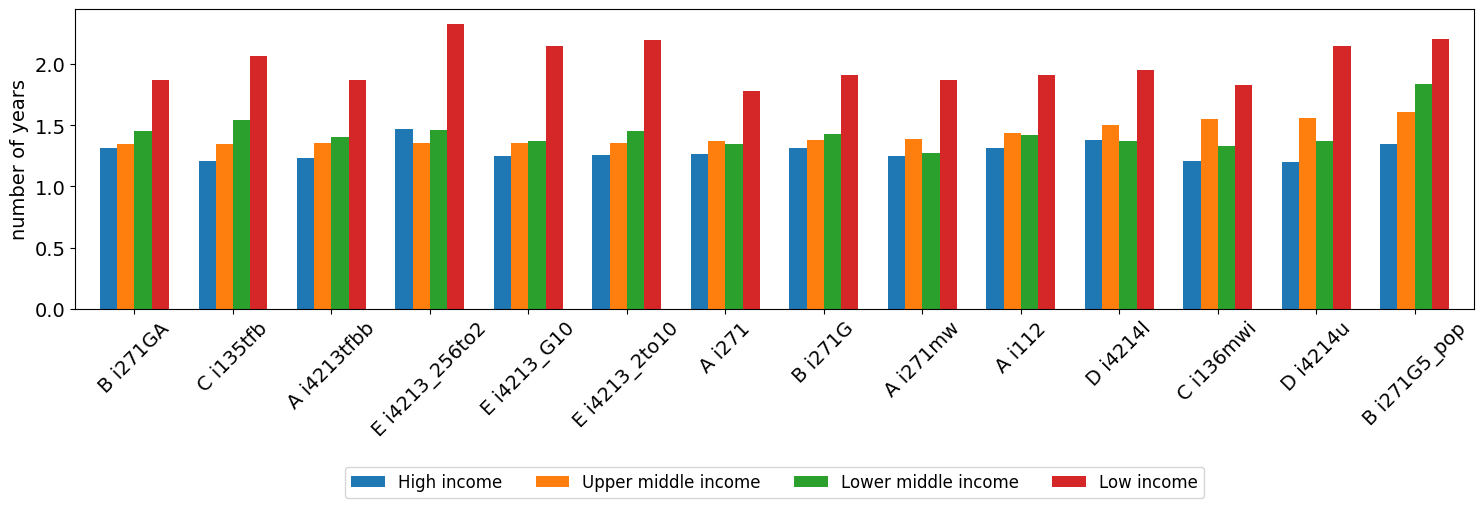

In [95]:
# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
#, 'Other Economies']

rename_dict = {
 'i112_timeliness': 'A i112',
 'i135tfb_timeliness': 'C i135tfb',
 'i136mwi_timeliness': 'C i136mwi',
 'i271_timeliness': 'A i271',
 'i271G_timeliness': 'B i271G',
 'i271G5_pop_timeliness': 'B i271G5_pop',
 'i271GA_timeliness': 'B i271GA',
 'i271mw_timeliness': 'A i271mw',
 'i4213_256to2_timeliness': 'E i4213_256to2',
 'i4213_2to10_timeliness': 'E i4213_2to10',
 'i4213_G10_timeliness': 'E i4213_G10',
 'i4213tfbb_timeliness': 'A i4213tfbb',
 'i4214l_timeliness': 'D i4214l',
 'i4214u_timeliness': 'D i4214u'
}

pivoted_t[['WB_Income','i112_timeliness',
       'i135tfb_timeliness', 'i136mwi_timeliness', 'i271_timeliness',
       'i271G_timeliness', 'i271G5_pop_timeliness', 'i271GA_timeliness',
       'i271mw_timeliness', 'i4213_256to2_timeliness',
       'i4213_2to10_timeliness', 'i4213_G10_timeliness',
       'i4213tfbb_timeliness', 'i4214l_timeliness', 'i4214u_timeliness']].rename(
     columns=rename_dict).groupby('WB_Income').mean(numeric_only=True).reindex(custom_order).T.sort_values(by='Upper middle income', ascending=True).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  #color=custom_colors,
                                                  width=0.7)
#plt.title('Timeliness in 2024: time lag of latest available data point in number of years (available data only)')
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.5),
    ncol=7,
    fontsize=12
)

plt.tight_layout()
plt.show()

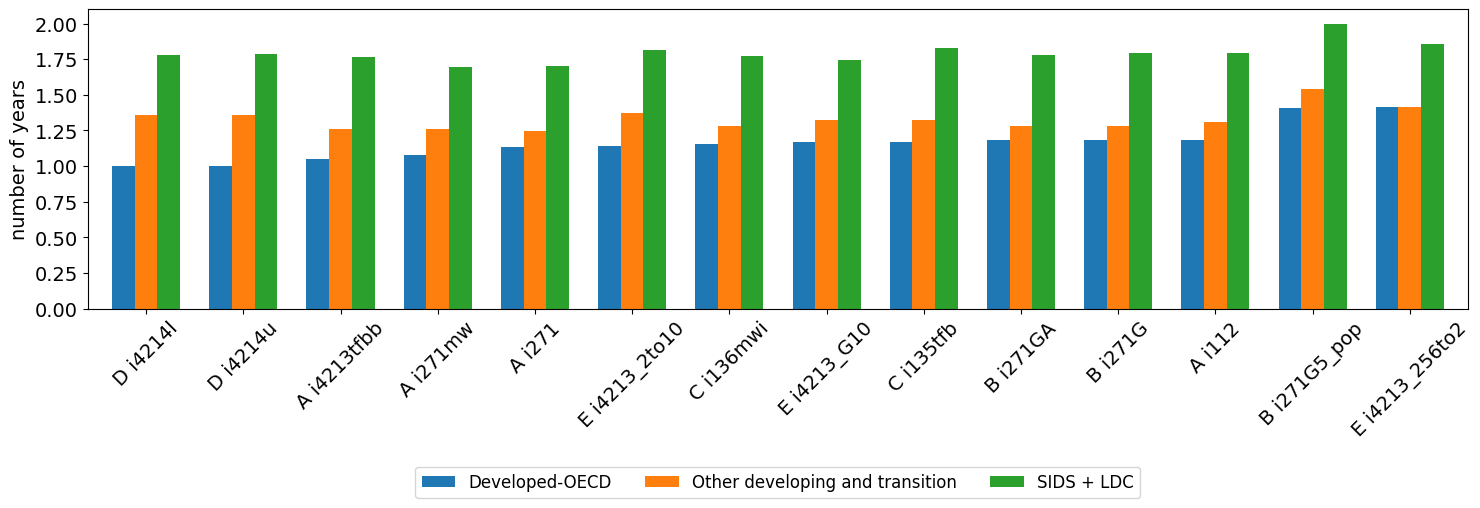

In [96]:
# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']
#, 'Other Economies']

rename_dict = {
 'i112_timeliness': 'A i112',
 'i135tfb_timeliness': 'C i135tfb',
 'i136mwi_timeliness': 'C i136mwi',
 'i271_timeliness': 'A i271',
 'i271G_timeliness': 'B i271G',
 'i271G5_pop_timeliness': 'B i271G5_pop',
 'i271GA_timeliness': 'B i271GA',
 'i271mw_timeliness': 'A i271mw',
 'i4213_256to2_timeliness': 'E i4213_256to2',
 'i4213_2to10_timeliness': 'E i4213_2to10',
 'i4213_G10_timeliness': 'E i4213_G10',
 'i4213tfbb_timeliness': 'A i4213tfbb',
 'i4214l_timeliness': 'D i4214l',
 'i4214u_timeliness': 'D i4214u'
}

pivoted_t[['new_group','i112_timeliness',
       'i135tfb_timeliness', 'i136mwi_timeliness', 'i271_timeliness',
       'i271G_timeliness', 'i271G5_pop_timeliness', 'i271GA_timeliness',
       'i271mw_timeliness', 'i4213_256to2_timeliness',
       'i4213_2to10_timeliness', 'i4213_G10_timeliness',
       'i4213tfbb_timeliness', 'i4214l_timeliness', 'i4214u_timeliness']].rename(
     columns=rename_dict).groupby('new_group').mean(numeric_only=True).reindex(custom_order).T.sort_values(by='Developed-OECD', ascending=True).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  #color=custom_colors,
                                                  width=0.7)
#plt.title('Timeliness in 2024: time lag of latest available data point in number of years (available data only)')
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.5),
    ncol=7,
    fontsize=12
)

plt.tight_layout()
plt.show()

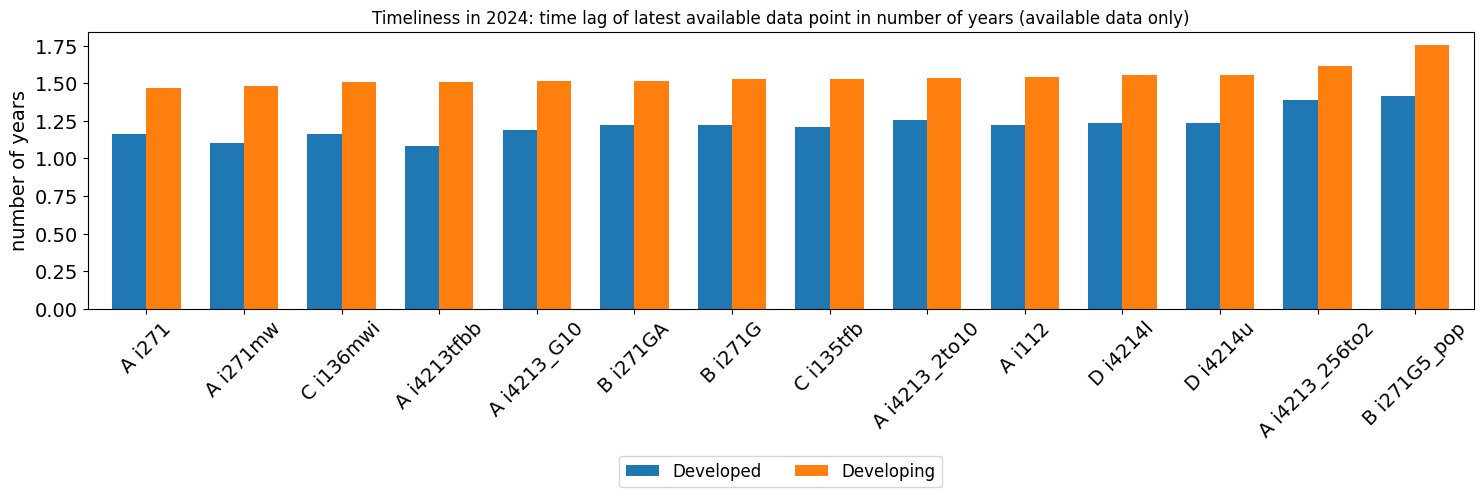

In [97]:
# Define your custom order
custom_order = ['Developed', 'Developing']
#, 'Other Economies']

rename_dict = {
 'i112_timeliness': 'A i112',
 'i135tfb_timeliness': 'C i135tfb',
 'i136mwi_timeliness': 'C i136mwi',
 'i271_timeliness': 'A i271',
 'i271G_timeliness': 'B i271G',
 'i271G5_pop_timeliness': 'B i271G5_pop',
 'i271GA_timeliness': 'B i271GA',
 'i271mw_timeliness': 'A i271mw',
 'i4213_256to2_timeliness': 'A i4213_256to2',
 'i4213_2to10_timeliness': 'A i4213_2to10',
 'i4213_G10_timeliness': 'A i4213_G10',
 'i4213tfbb_timeliness': 'A i4213tfbb',
 'i4214l_timeliness': 'D i4214l',
 'i4214u_timeliness': 'D i4214u'
}

pivoted_t[['CountryType','i112_timeliness',
       'i135tfb_timeliness', 'i136mwi_timeliness', 'i271_timeliness',
       'i271G_timeliness', 'i271G5_pop_timeliness', 'i271GA_timeliness',
       'i271mw_timeliness', 'i4213_256to2_timeliness',
       'i4213_2to10_timeliness', 'i4213_G10_timeliness',
       'i4213tfbb_timeliness', 'i4214l_timeliness', 'i4214u_timeliness']].rename(
     columns=rename_dict).groupby('CountryType').mean(numeric_only=True).reindex(custom_order).T.sort_values(by='Developing', ascending=True).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  #color=custom_colors,
                                                  width=0.7)
plt.title('Timeliness in 2024: time lag of latest available data point in number of years (available data only)')
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.5),
    ncol=7,
    fontsize=12
)

plt.tight_layout()
plt.show()

## Charts for country profile

In [98]:
pivoted_t[pivoted_t.ShortName=='Madagascar'][['RegionName','i112_timeliness',
       'i135tfb_timeliness', 'i136mwi_timeliness', 'i271_timeliness',
       'i271G_timeliness', 'i271G5_pop_timeliness', 'i271GA_timeliness',
       'i271mw_timeliness', 'i4213_256to2_timeliness',
       'i4213_2to10_timeliness', 'i4213_G10_timeliness',
       'i4213tfbb_timeliness', 'i4214l_timeliness', 'i4214u_timeliness']]

,RegionName,i112_timeliness,i135tfb_timeliness,i136mwi_timeliness,i271_timeliness,i271G_timeliness,i271G5_pop_timeliness,i271GA_timeliness,i271mw_timeliness,i4213_256to2_timeliness,i4213_2to10_timeliness,i4213_G10_timeliness,i4213tfbb_timeliness,i4214l_timeliness,i4214u_timeliness
97,Africa,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


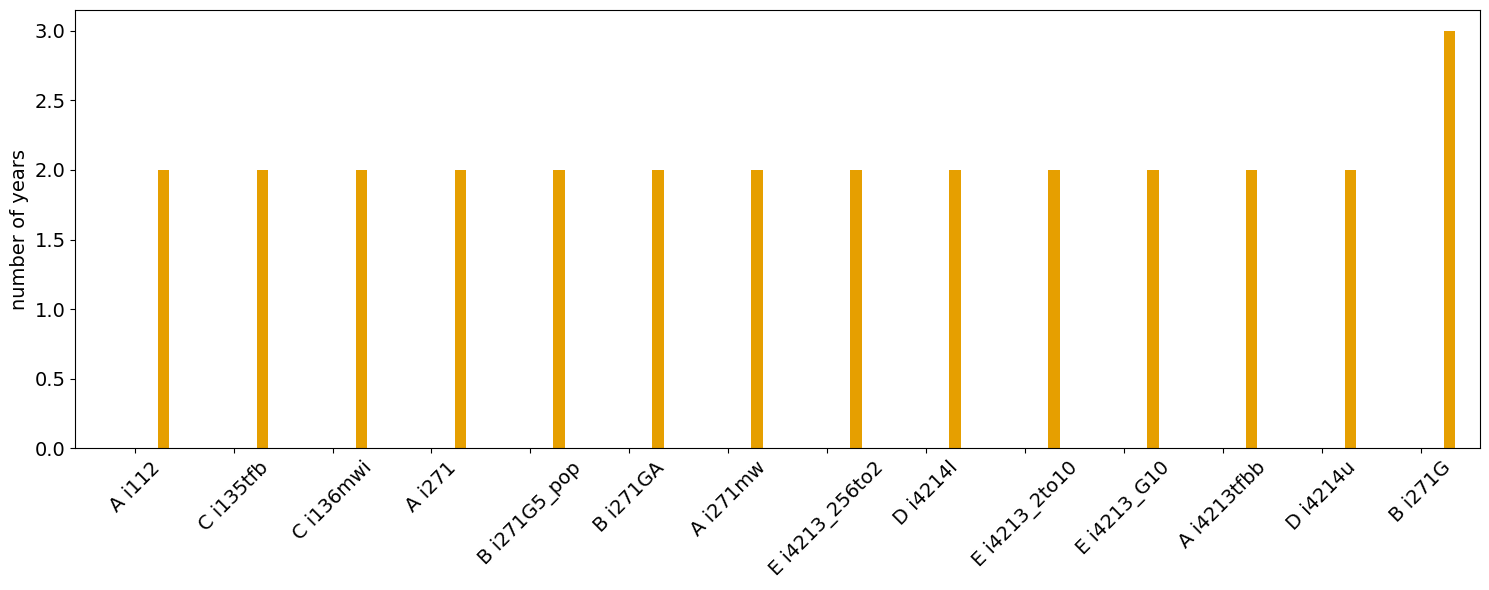

In [99]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]

rename_dict = {
 'i112_timeliness': 'A i112',
 'i135tfb_timeliness': 'C i135tfb',
 'i136mwi_timeliness': 'C i136mwi',
 'i271_timeliness': 'A i271',
 'i271G_timeliness': 'B i271G',
 'i271G5_pop_timeliness': 'B i271G5_pop',
 'i271GA_timeliness': 'B i271GA',
 'i271mw_timeliness': 'A i271mw',
 'i4213_256to2_timeliness': 'E i4213_256to2',
 'i4213_2to10_timeliness': 'E i4213_2to10',
 'i4213_G10_timeliness': 'E i4213_G10',
 'i4213tfbb_timeliness': 'A i4213tfbb',
 'i4214l_timeliness': 'D i4214l',
 'i4214u_timeliness': 'D i4214u'
}

pivoted_t[pivoted_t.ShortName=='Madagascar'][['RegionName','i112_timeliness',
       'i135tfb_timeliness', 'i136mwi_timeliness', 'i271_timeliness',
       'i271G_timeliness', 'i271G5_pop_timeliness', 'i271GA_timeliness',
       'i271mw_timeliness', 'i4213_256to2_timeliness',
       'i4213_2to10_timeliness', 'i4213_G10_timeliness',
       'i4213tfbb_timeliness', 'i4214l_timeliness', 'i4214u_timeliness']].rename(
     columns=rename_dict).groupby('RegionName').mean(numeric_only=True).reindex(custom_order).T.sort_values(by='Africa', ascending=True).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  color=custom_colors,
                                                  width=0.7)
#plt.title('Timeliness in 2024: time lag of latest available data point in number of years (available data only)')
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.5),
    ncol=7,
    fontsize=12
)
plt.legend().remove()

plt.tight_layout()
plt.show()

## Group-wise calculations for timeliness (by group of indicators)

Now group the data so we can report timeliness for the categories of indicators

In [100]:
wti_timeliness.head()

,ShortName,Code,RegionName,Code description,IsoCode,wti_group,new_group,CountryType,WB_Income,timeliness
0,Afghanistan,i112,Asia & Pacific,Fixed-telephone subscriptions,AFG,A. Contracting_records,SIDS + LDC,Developing,Low income,2
1,Afghanistan,i135tfb,Asia & Pacific,Fixed-broadband Internet traffic (exabytes),AFG,C. Operator_traffic,SIDS + LDC,Developing,Low income,5
2,Afghanistan,i136mwi,Asia & Pacific,Mobile-broadband Internet traffic (within the ...,AFG,C. Operator_traffic,SIDS + LDC,Developing,Low income,2
3,Afghanistan,i271,Asia & Pacific,"Mobile-cellular telephone subscriptions, by po...",AFG,A. Contracting_records,SIDS + LDC,Developing,Low income,2
4,Afghanistan,i271G,Asia & Pacific,Percentage of the population covered by at lea...,AFG,B. Cell_tower_coverage,SIDS + LDC,Developing,Low income,2


In [101]:
# Make calculations for the group of indicators - take the minimum per group

wti_timeliness.groupby(["ShortName", "RegionName", "wti_group", "IsoCode", 'new_group', 'CountryType', 'WB_Income'], as_index=False)["timeliness"].min().head()

,ShortName,RegionName,wti_group,IsoCode,new_group,CountryType,WB_Income,timeliness
0,Afghanistan,Asia & Pacific,A. Contracting_records,AFG,SIDS + LDC,Developing,Low income,2
1,Afghanistan,Asia & Pacific,B. Cell_tower_coverage,AFG,SIDS + LDC,Developing,Low income,2
2,Afghanistan,Asia & Pacific,C. Operator_traffic,AFG,SIDS + LDC,Developing,Low income,2
3,Afghanistan,Asia & Pacific,D. Operators_wholesale,AFG,SIDS + LDC,Developing,Low income,2
4,Afghanistan,Asia & Pacific,E. Contracting_fixed_broadband_speed,AFG,SIDS + LDC,Developing,Low income,5


In [102]:
# check the range of timeliness
wti_timeliness.groupby(["ShortName", "RegionName", "wti_group", "IsoCode", 'new_group', 'CountryType', 'WB_Income'], as_index=False)["timeliness"].min().timeliness.describe()

,timeliness
count,839.0
mean,1.417163
std,0.872541
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,5.0


In [103]:
wti_time_group = wti_timeliness.groupby(["ShortName", "RegionName", "wti_group", "IsoCode", 'new_group', 'CountryType', 'WB_Income'], as_index=False)["timeliness"].min()

# the percentage column is only needed at the later stage when computing the sub-index


pivoted_t_group = wti_time_group.pivot(index=['ShortName', 'RegionName', 'IsoCode', 'new_group', 'CountryType', 'WB_Income'], columns='wti_group', values=['timeliness'])

# Pivot back my data so I can plot it
# Replace NaNs with 6 because the data must be older than 2025-2020 =5 years
# pivoted_t_group = pivoted_t_group.fillna(6)

# Flatten and rename the columns
pivoted_t_group.columns = [
    f"{indicator}_{suffix}"
    for suffix, indicator in pivoted_t_group.columns
]

pivoted_t_group.reset_index(inplace=True)

pivoted_t_group.head()

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,A. Contracting_records_timeliness,B. Cell_tower_coverage_timeliness,C. Operator_traffic_timeliness,D. Operators_wholesale_timeliness,E. Contracting_fixed_broadband_speed_timeliness
0,Afghanistan,Asia & Pacific,AFG,SIDS + LDC,Developing,Low income,2.0,2.0,2.0,2.0,5.0
1,Albania,Europe countries,ALB,Other developing and transition,Developed,Upper middle income,1.0,1.0,1.0,1.0,1.0
2,Algeria,Arab States,DZA,Other developing and transition,Developing,Lower middle income,1.0,1.0,1.0,1.0,1.0
3,Andorra,Europe countries,AND,Other developing and transition,Developed,High income,1.0,1.0,1.0,1.0,1.0
4,Angola,Africa,AGO,SIDS + LDC,Developing,Lower middle income,1.0,1.0,1.0,1.0,1.0


In [104]:
pivoted_t_group.columns

Index(['ShortName', 'RegionName', 'IsoCode', 'new_group', 'CountryType',
       'WB_Income', 'A. Contracting_records_timeliness',
       'B. Cell_tower_coverage_timeliness', 'C. Operator_traffic_timeliness',
       'D. Operators_wholesale_timeliness',
       'E. Contracting_fixed_broadband_speed_timeliness'],
      dtype='object')

In [149]:
pivoted_t_group[['ShortName', 'RegionName','A. Contracting_records_timeliness',
       'B. Cell_tower_coverage_timeliness', 'C. Operator_traffic_timeliness',
       'D. Operators_wholesale_timeliness',
       'E. Contracting_fixed_broadband_speed_timeliness']][pivoted_t_group.RegionName== 'CIS countries']

,ShortName,RegionName,A. Contracting_records_timeliness,B. Cell_tower_coverage_timeliness,C. Operator_traffic_timeliness,D. Operators_wholesale_timeliness,E. Contracting_fixed_broadband_speed_timeliness
7,Armenia,CIS countries,1.0,1.0,1.0,1.0,1.0
10,Azerbaijan,CIS countries,1.0,1.0,1.0,1.0,1.0
15,Belarus,CIS countries,1.0,1.0,1.0,1.0,1.0
81,Kazakhstan,CIS countries,1.0,1.0,1.0,1.0,1.0
86,Kyrgyzstan,CIS countries,1.0,1.0,1.0,1.0,1.0
135,Russian Federation,CIS countries,1.0,1.0,1.0,2.0,1.0
162,Tajikistan,CIS countries,2.0,NaN,NaN,NaN,NaN
170,Turkmenistan,CIS countries,3.0,NaN,NaN,4.0,3.0
178,Uzbekistan,CIS countries,1.0,1.0,1.0,1.0,1.0


In [105]:
pivoted_t_group[['A. Contracting_records_timeliness',
       'B. Cell_tower_coverage_timeliness', 'C. Operator_traffic_timeliness',
       'D. Operators_wholesale_timeliness',
       'E. Contracting_fixed_broadband_speed_timeliness']].describe()

,A. Contracting_records_timeliness,B. Cell_tower_coverage_timeliness,C. Operator_traffic_timeliness,D. Operators_wholesale_timeliness,E. Contracting_fixed_broadband_speed_timeliness
count,184.000000,181.000000,167.000000,139.000000,168.000000
mean,1.353261,1.419890,1.401198,1.503597,1.428571
std,0.789404,0.816797,0.944610,0.973371,0.858710
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,2.000000,1.000000,2.000000,1.250000
max,5.000000,5.000000,5.000000,5.000000,5.000000


In [106]:
# these are the countries with the lowest timeliness values (5) per group of indicator, not accounting for missing values
pivoted_t_group[pivoted_t_group[['A. Contracting_records_timeliness',
       'B. Cell_tower_coverage_timeliness', 'C. Operator_traffic_timeliness',
       'D. Operators_wholesale_timeliness',
       'E. Contracting_fixed_broadband_speed_timeliness']].ge(5).any(axis=1)]

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,A. Contracting_records_timeliness,B. Cell_tower_coverage_timeliness,C. Operator_traffic_timeliness,D. Operators_wholesale_timeliness,E. Contracting_fixed_broadband_speed_timeliness
0,Afghanistan,Asia & Pacific,AFG,SIDS + LDC,Developing,Low income,2.0,2.0,2.0,2.0,5.0
5,Antigua and Barbuda,The Americas,ATG,SIDS + LDC,Developing,High income,5.0,5.0,NaN,NaN,NaN
46,Dominica,The Americas,DMA,SIDS + LDC,Developing,Upper middle income,3.0,3.0,5.0,NaN,3.0
58,Gabon,Africa,GAB,Other developing and transition,Developing,Upper middle income,1.0,1.0,5.0,1.0,1.0
64,Grenada,The Americas,GRD,SIDS + LDC,Developing,Upper middle income,3.0,3.0,5.0,3.0,3.0
89,Lebanon,Arab States,LBN,Other developing and transition,Developing,Lower middle income,5.0,5.0,5.0,5.0,5.0
128,Paraguay,The Americas,PRY,Other developing and transition,Developing,Upper middle income,2.0,2.0,5.0,2.0,2.0
138,Saint Lucia,The Americas,LCA,SIDS + LDC,Developing,Upper middle income,3.0,3.0,5.0,3.0,3.0
139,Saint Vincent and the Grenadines,The Americas,VCT,SIDS + LDC,Developing,Upper middle income,1.0,1.0,1.0,5.0,4.0


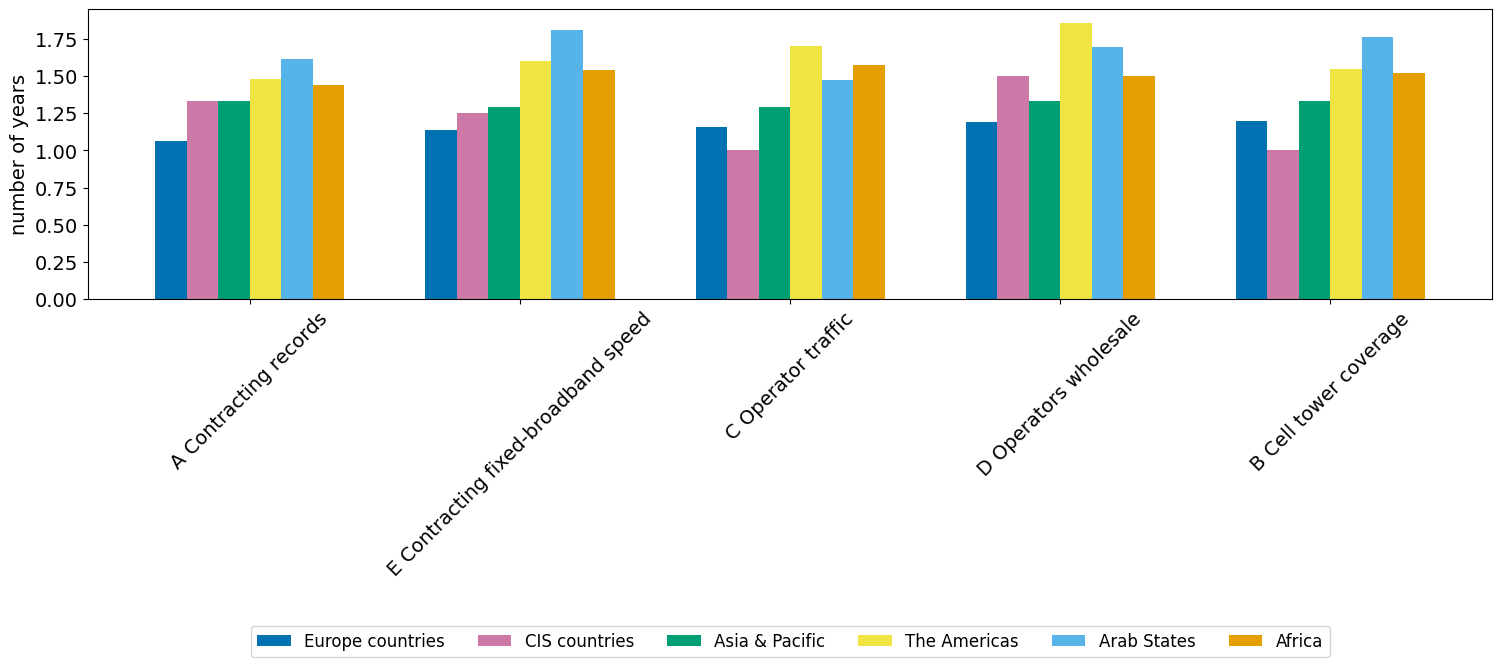

In [107]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]

rename_dict = {
'B. Cell_tower_coverage_timeliness': "B Cell tower coverage",
'A. Contracting_records_timeliness':"A Contracting records",
'C. Operator_traffic_timeliness':"C Operator traffic",
'D. Operators_wholesale_timeliness':"D Operators wholesale",
'E. Contracting_fixed_broadband_speed_timeliness': "E Contracting fixed-broadband speed"
}

pivoted_t_group[['RegionName','B. Cell_tower_coverage_timeliness',
       'A. Contracting_records_timeliness', 'C. Operator_traffic_timeliness',
       'D. Operators_wholesale_timeliness', 'E. Contracting_fixed_broadband_speed_timeliness']].rename(
     columns=rename_dict).groupby('RegionName').mean(numeric_only=True).reindex(custom_order).T.sort_values(by='Europe countries', ascending=True).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  color=custom_colors,
                                                  width=0.7)
#plt.title('Timeliness in 2025: time lag of latest available data point in number of years (available data only)')
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# adjust bottom margin to make space for legend
plt.subplots_adjust(bottom=0.6)  # increase bottom space

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -1.1),
    ncol=7,
    fontsize=12
)

plt.tight_layout()
plt.show()

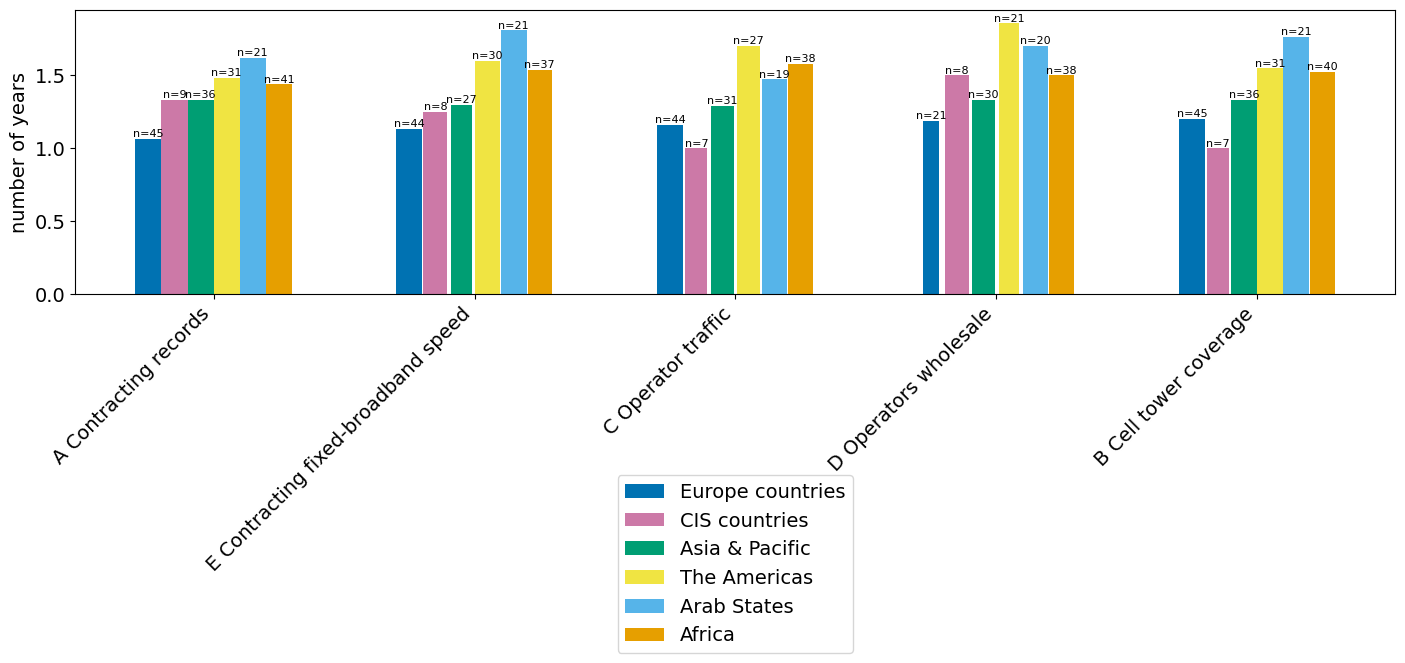

In [141]:
from matplotlib.patches import Patch

# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    ]

rename_dict = {
'B. Cell_tower_coverage_timeliness': "B Cell tower coverage",
'A. Contracting_records_timeliness':"A Contracting records",
'C. Operator_traffic_timeliness':"C Operator traffic",
'D. Operators_wholesale_timeliness':"D Operators wholesale",
'E. Contracting_fixed_broadband_speed_timeliness': "E Contracting fixed-broadband speed"
}

subset = pivoted_t_group[['RegionName','B. Cell_tower_coverage_timeliness',
       'A. Contracting_records_timeliness', 'C. Operator_traffic_timeliness',
       'D. Operators_wholesale_timeliness', 'E. Contracting_fixed_broadband_speed_timeliness']].rename(
     columns=rename_dict)

# Calculate means and counts
means = subset.groupby('RegionName').mean(numeric_only=True).T
counts = subset.groupby('RegionName').count().T

# Sort by Europe countries
means_sorted = means.sort_values(by='Europe countries', ascending=True)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each region separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

for i, region in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[region].max()

    # Normalize within the group
    width_factors = counts_sorted[region] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[region].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=custom_colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[region].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=8,
                rotation=0
            )

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('number of years', fontsize=14)
#plt.title('Timeliness in 2025: time lag of latest available data point in number of years (available data only)')
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=14, ha='right')
ax.tick_params(axis='y', labelsize=14)

# Create custom legend
legend_handles = [Patch(facecolor=custom_colors[i], label=region)
                  for i, region in enumerate(custom_order)]

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=1,
    fontsize=14
)

plt.tight_layout()
plt.show()



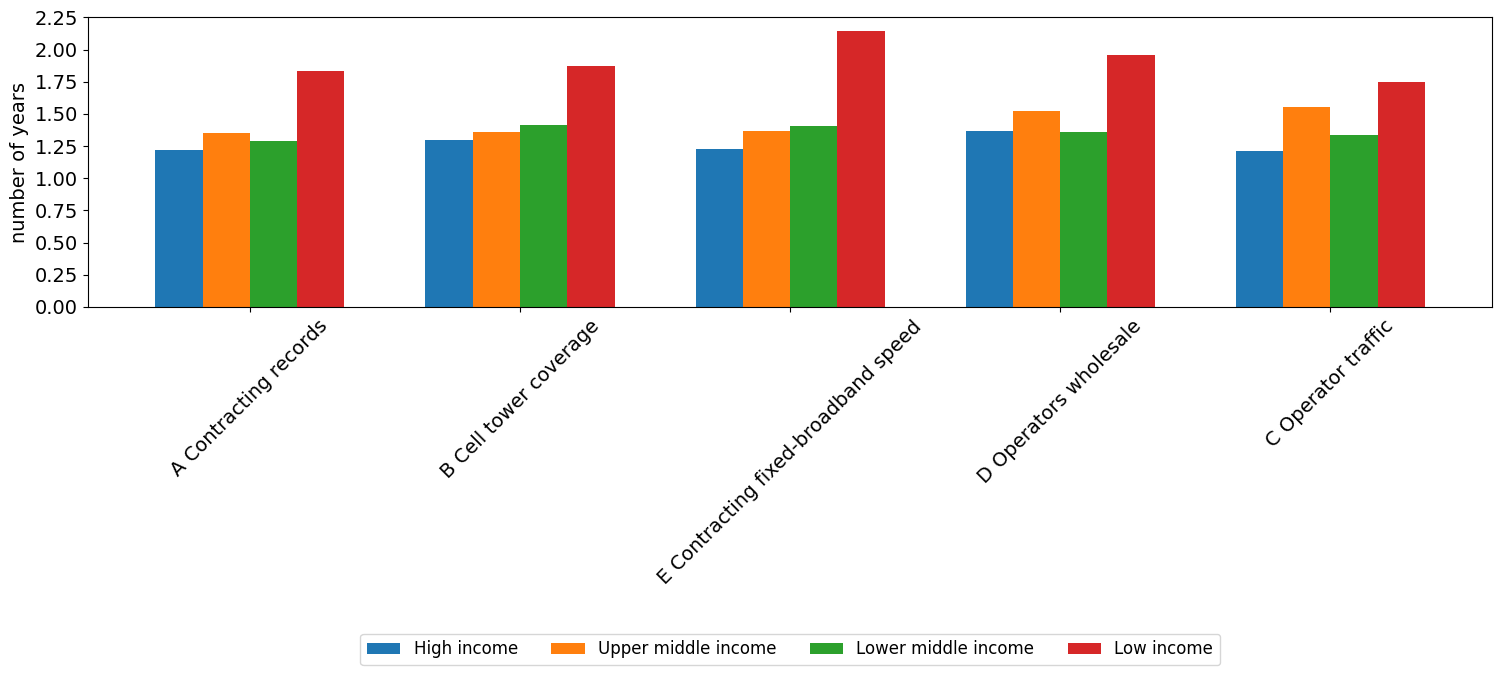

In [108]:
# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
#, 'Other Economies']

rename_dict = {
'B. Cell_tower_coverage_timeliness': "B Cell tower coverage",
'A. Contracting_records_timeliness':"A Contracting records",
'C. Operator_traffic_timeliness':"C Operator traffic",
'D. Operators_wholesale_timeliness':"D Operators wholesale",
'E. Contracting_fixed_broadband_speed_timeliness': "E Contracting fixed-broadband speed"
}

pivoted_t_group[['WB_Income','B. Cell_tower_coverage_timeliness',
       'A. Contracting_records_timeliness', 'C. Operator_traffic_timeliness',
       'D. Operators_wholesale_timeliness', 'E. Contracting_fixed_broadband_speed_timeliness']].rename(
     columns=rename_dict).groupby('WB_Income').mean(numeric_only=True).reindex(custom_order).T.sort_values(by='Upper middle income', ascending=True).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  #color=custom_colors,
                                                  width=0.7)
#plt.title('Timeliness in 2025: time lag of latest available data point in number of years (available data only)')
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# adjust bottom margin to make space for legend
plt.subplots_adjust(bottom=0.6)  # increase bottom space

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -1.1),
    ncol=7,
    fontsize=12
)

plt.tight_layout()
plt.show()

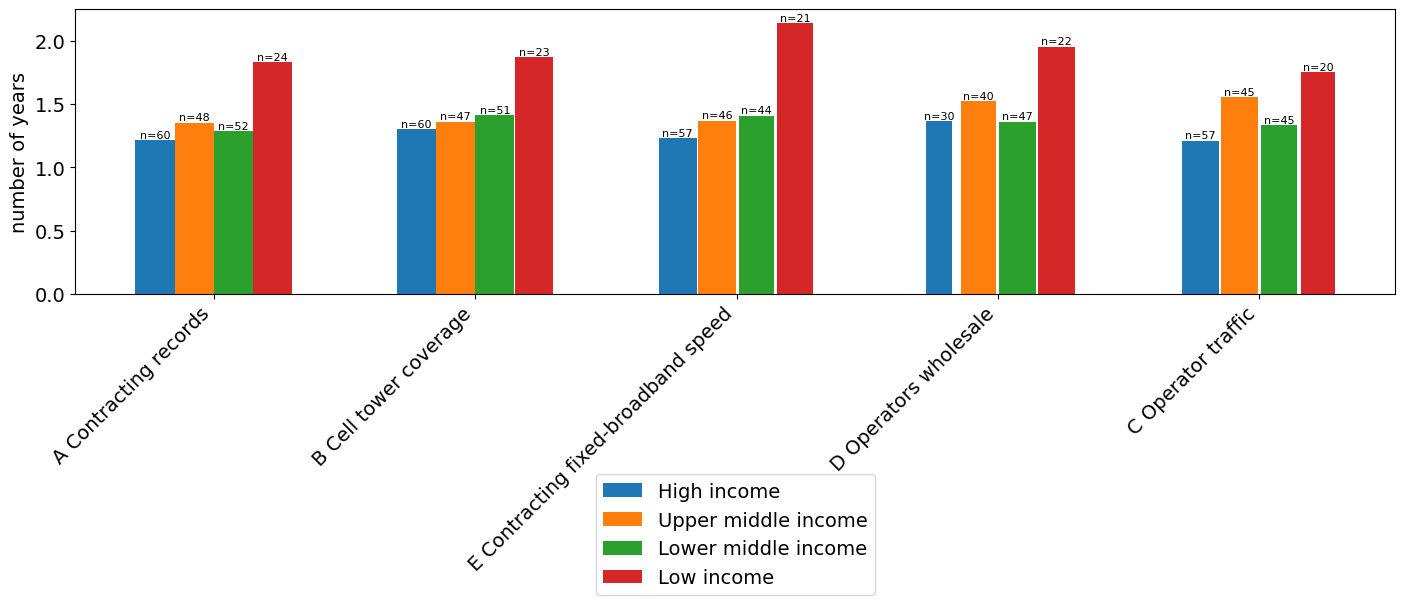

In [145]:
from matplotlib.patches import Patch

# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
#, 'Other Economies']

rename_dict = {
'B. Cell_tower_coverage_timeliness': "B Cell tower coverage",
'A. Contracting_records_timeliness':"A Contracting records",
'C. Operator_traffic_timeliness':"C Operator traffic",
'D. Operators_wholesale_timeliness':"D Operators wholesale",
'E. Contracting_fixed_broadband_speed_timeliness': "E Contracting fixed-broadband speed"
}

custom_colors = ['#1f77b4',  # Blue
'#ff7f0e' , # Orange
'#2ca02c',  # Green
'#d62728'  # Red
]

subset = pivoted_t_group[['WB_Income','B. Cell_tower_coverage_timeliness',
       'A. Contracting_records_timeliness', 'C. Operator_traffic_timeliness',
       'D. Operators_wholesale_timeliness', 'E. Contracting_fixed_broadband_speed_timeliness']].rename(
     columns=rename_dict)

# Calculate means and counts
means = subset.groupby('WB_Income').mean(numeric_only=True).T
counts = subset.groupby('WB_Income').count().T

# Sort by Europe countries
means_sorted = means.sort_values(by='Upper middle income', ascending=True)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each region separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

for i, region in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[region].max()

    # Normalize within the group
    width_factors = counts_sorted[region] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[region].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=custom_colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[region].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=8,
                rotation=0
            )

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('number of years', fontsize=14)
#plt.title('Timeliness in 2025: time lag of latest available data point in number of years (available data only)')
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=14, ha='right')
ax.tick_params(axis='y', labelsize=14)

# Create custom legend
legend_handles = [Patch(facecolor=custom_colors[i], label=region)
                  for i, region in enumerate(custom_order)] #

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=1,
    fontsize=14
)

plt.tight_layout()
plt.show()



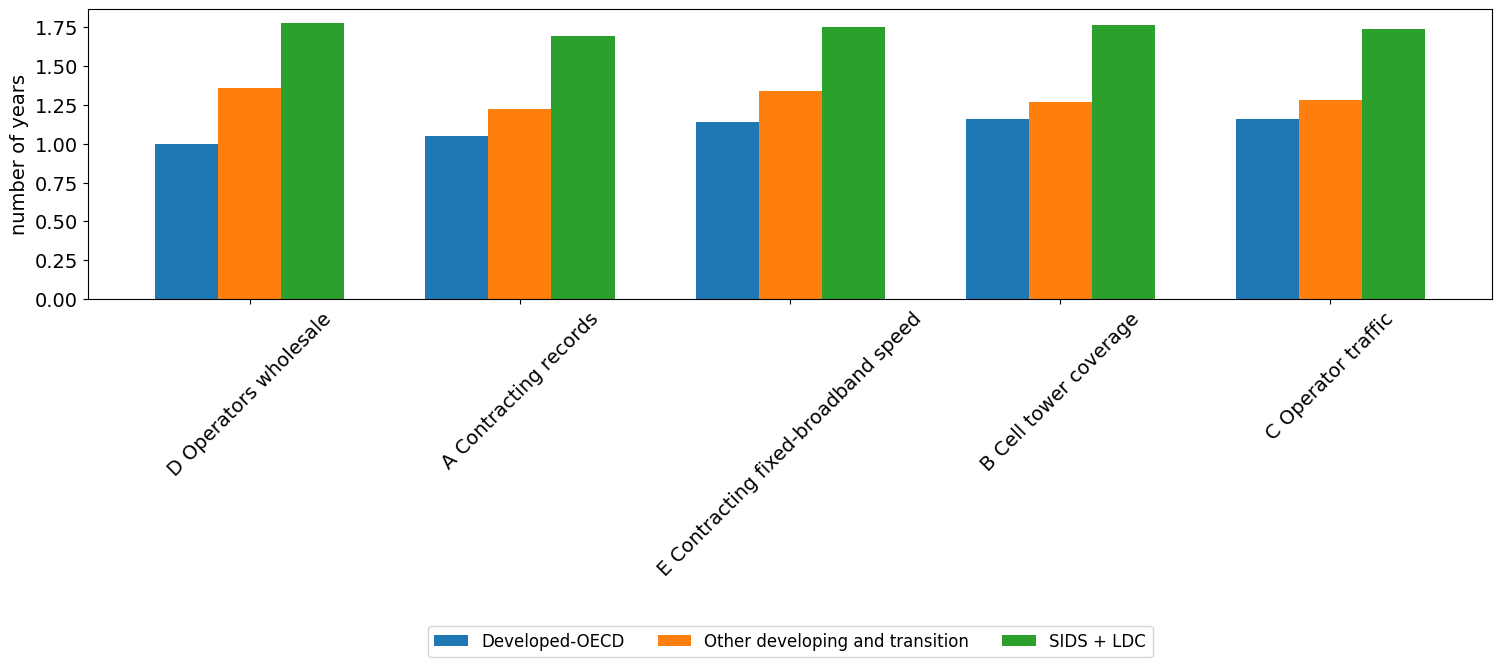

In [109]:
# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']
#, 'Other Economies']

rename_dict = {
'B. Cell_tower_coverage_timeliness': "B Cell tower coverage",
'A. Contracting_records_timeliness':"A Contracting records",
'C. Operator_traffic_timeliness':"C Operator traffic",
'D. Operators_wholesale_timeliness':"D Operators wholesale",
'E. Contracting_fixed_broadband_speed_timeliness': "E Contracting fixed-broadband speed"
}

pivoted_t_group[['new_group','B. Cell_tower_coverage_timeliness',
       'A. Contracting_records_timeliness', 'C. Operator_traffic_timeliness',
       'D. Operators_wholesale_timeliness', 'E. Contracting_fixed_broadband_speed_timeliness']].rename(
     columns=rename_dict).groupby('new_group').mean(numeric_only=True).reindex(custom_order).T.sort_values(by='Developed-OECD', ascending=True).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  #color=custom_colors,
                                                  width=0.7)
#plt.title('Timeliness in 2025: time lag of latest available data point in number of years (available data only)')
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# adjust bottom margin to make space for legend
plt.subplots_adjust(bottom=0.6)  # increase bottom space

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -1.1),
    ncol=7,
    fontsize=12
)

plt.tight_layout()
plt.show()

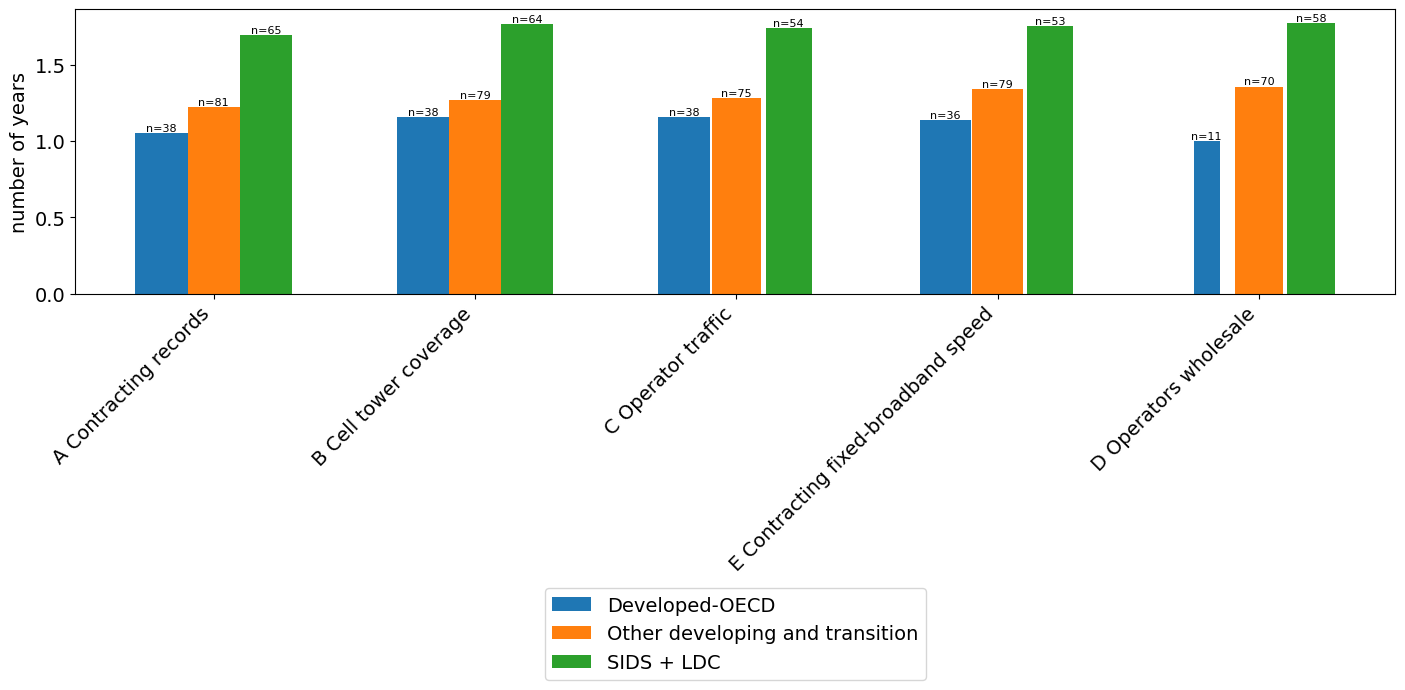

In [155]:
from matplotlib.patches import Patch

# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']
#, 'Other Economies']

rename_dict = {
'B. Cell_tower_coverage_timeliness': "B Cell tower coverage",
'A. Contracting_records_timeliness':"A Contracting records",
'C. Operator_traffic_timeliness':"C Operator traffic",
'D. Operators_wholesale_timeliness':"D Operators wholesale",
'E. Contracting_fixed_broadband_speed_timeliness': "E Contracting fixed-broadband speed"
}

custom_colors = ['#1f77b4',  # Blue
'#ff7f0e' , # Orange
'#2ca02c',  # Green
'#d62728'  # Red
]

subset = pivoted_t_group[['new_group','B. Cell_tower_coverage_timeliness',
       'A. Contracting_records_timeliness', 'C. Operator_traffic_timeliness',
       'D. Operators_wholesale_timeliness', 'E. Contracting_fixed_broadband_speed_timeliness']].rename(
     columns=rename_dict)

# Calculate means and counts
means = subset.groupby('new_group').mean(numeric_only=True).T
counts = subset.groupby('new_group').count().T

# Sort by Europe countries
means_sorted = means.sort_values(by='Other developing and transition', ascending=True)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each region separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

for i, region in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[region].max()

    # Normalize within the group
    width_factors = counts_sorted[region] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[region].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=custom_colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[region].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=8,
                rotation=0
            )

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('number of years', fontsize=14)
#plt.title('Timeliness in 2025: time lag of latest available data point in number of years (available data only)')
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=14, ha='right')
ax.tick_params(axis='y', labelsize=14)

# Create custom legend
legend_handles = [Patch(facecolor=custom_colors[i], label=region)
                  for i, region in enumerate(custom_order)] #

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -1.0),
    ncol=1,
    fontsize=14
)

plt.tight_layout()
plt.show()



In [110]:
# for oecd countries, the only data available is the one below and timeliness averages to 0⁄
wti_timeliness[(wti_timeliness.new_group=='Developed-OECD') & (wti_timeliness.wti_group=='D. Operators_wholesale')]

,ShortName,Code,RegionName,Code description,IsoCode,wti_group,new_group,CountryType,WB_Income,timeliness
421,Chile,i4214u,The Americas,"International bandwidth usage, in Mbit/s",CHL,D. Operators_wholesale,Developed-OECD,Developing,High income,1
448,Colombia,i4214l,The Americas,"Lit/equipped international bandwidth capacity,...",COL,D. Operators_wholesale,Developed-OECD,Developing,Upper middle income,1
449,Colombia,i4214u,The Americas,"International bandwidth usage, in Mbit/s",COL,D. Operators_wholesale,Developed-OECD,Developing,Upper middle income,1
490,Costa Rica,i4214l,The Americas,"Lit/equipped international bandwidth capacity,...",CRI,D. Operators_wholesale,Developed-OECD,Developing,Upper middle income,1
819,Greece,i4214l,Europe countries,"Lit/equipped international bandwidth capacity,...",GRC,D. Operators_wholesale,Developed-OECD,Developed,High income,1
820,Greece,i4214u,Europe countries,"International bandwidth usage, in Mbit/s",GRC,D. Operators_wholesale,Developed-OECD,Developed,High income,1
912,Iceland,i4214l,Europe countries,"Lit/equipped international bandwidth capacity,...",ISL,D. Operators_wholesale,Developed-OECD,Developed,High income,1
913,Iceland,i4214u,Europe countries,"International bandwidth usage, in Mbit/s",ISL,D. Operators_wholesale,Developed-OECD,Developed,High income,1
1098,Korea (Rep. of),i4214l,Asia & Pacific,"Lit/equipped international bandwidth capacity,...",KOR,D. Operators_wholesale,Developed-OECD,Developing,High income,1
1213,Lithuania,i4214l,Europe countries,"Lit/equipped international bandwidth capacity,...",LTU,D. Operators_wholesale,Developed-OECD,Developed,High income,1


In [111]:
pivoted_t[pivoted_t.ShortName=='Afghanistan']

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,i112_timeliness,i135tfb_timeliness,i136mwi_timeliness,i271_timeliness,...,i271G5_pop_timeliness,i271GA_timeliness,i271mw_timeliness,i4213_256to2_timeliness,i4213_2to10_timeliness,i4213_G10_timeliness,i4213tfbb_timeliness,i4214l_timeliness,i4214u_timeliness,timeliness
0,Afghanistan,Asia & Pacific,AFG,SIDS + LDC,Developing,Low income,2.0,5.0,2.0,2.0,...,4.0,2.0,2.0,5.0,5.0,5.0,2.0,2.0,2.0,3.0


In [112]:
wti_timeliness[wti_timeliness.ShortName=='Afghanistan']

,ShortName,Code,RegionName,Code description,IsoCode,wti_group,new_group,CountryType,WB_Income,timeliness
0,Afghanistan,i112,Asia & Pacific,Fixed-telephone subscriptions,AFG,A. Contracting_records,SIDS + LDC,Developing,Low income,2
1,Afghanistan,i135tfb,Asia & Pacific,Fixed-broadband Internet traffic (exabytes),AFG,C. Operator_traffic,SIDS + LDC,Developing,Low income,5
2,Afghanistan,i136mwi,Asia & Pacific,Mobile-broadband Internet traffic (within the ...,AFG,C. Operator_traffic,SIDS + LDC,Developing,Low income,2
3,Afghanistan,i271,Asia & Pacific,"Mobile-cellular telephone subscriptions, by po...",AFG,A. Contracting_records,SIDS + LDC,Developing,Low income,2
4,Afghanistan,i271G,Asia & Pacific,Percentage of the population covered by at lea...,AFG,B. Cell_tower_coverage,SIDS + LDC,Developing,Low income,2
5,Afghanistan,i271G5_pop,Asia & Pacific,Percentage of the population covered by at lea...,AFG,B. Cell_tower_coverage,SIDS + LDC,Developing,Low income,4
6,Afghanistan,i271GA,Asia & Pacific,Percentage of the population covered by at lea...,AFG,B. Cell_tower_coverage,SIDS + LDC,Developing,Low income,2
7,Afghanistan,i271mw,Asia & Pacific,Active mobile-broadband subscriptions,AFG,A. Contracting_records,SIDS + LDC,Developing,Low income,2
8,Afghanistan,i4213_256to2,Asia & Pacific,"Fixed broadband, 256 kbit/s to less than 2 Mbi...",AFG,E. Contracting_fixed_broadband_speed,SIDS + LDC,Developing,Low income,5
9,Afghanistan,i4213_2to10,Asia & Pacific,"Fixed broadband, 2 Mbit/s to less than 10 Mbit...",AFG,E. Contracting_fixed_broadband_speed,SIDS + LDC,Developing,Low income,5


In [113]:
wti_counts[wti_counts.ShortName=='Afghanistan']

,ShortName,Code,RegionName,Code description,wti_group,IsoCode,new_group,CountryType,WB_Income,5Y,5Y_p
0,Afghanistan,i112,Asia & Pacific,Fixed-telephone subscriptions,A. Contracting_records,AFG,SIDS + LDC,Developing,Low income,4,80.0
1,Afghanistan,i135tfb,Asia & Pacific,Fixed-broadband Internet traffic (exabytes),C. Operator_traffic,AFG,SIDS + LDC,Developing,Low income,1,20.0
2,Afghanistan,i136mwi,Asia & Pacific,Mobile-broadband Internet traffic (within the ...,C. Operator_traffic,AFG,SIDS + LDC,Developing,Low income,3,60.0
3,Afghanistan,i271,Asia & Pacific,"Mobile-cellular telephone subscriptions, by po...",A. Contracting_records,AFG,SIDS + LDC,Developing,Low income,4,80.0
4,Afghanistan,i271G,Asia & Pacific,Percentage of the population covered by at lea...,B. Cell_tower_coverage,AFG,SIDS + LDC,Developing,Low income,4,80.0
5,Afghanistan,i271G5_pop,Asia & Pacific,Percentage of the population covered by at lea...,B. Cell_tower_coverage,AFG,SIDS + LDC,Developing,Low income,1,20.0
6,Afghanistan,i271GA,Asia & Pacific,Percentage of the population covered by at lea...,B. Cell_tower_coverage,AFG,SIDS + LDC,Developing,Low income,4,80.0
7,Afghanistan,i271mw,Asia & Pacific,Active mobile-broadband subscriptions,A. Contracting_records,AFG,SIDS + LDC,Developing,Low income,4,80.0
8,Afghanistan,i4213_256to2,Asia & Pacific,"Fixed broadband, 256 kbit/s to less than 2 Mbi...",E. Contracting_fixed_broadband_speed,AFG,SIDS + LDC,Developing,Low income,1,20.0
9,Afghanistan,i4213_2to10,Asia & Pacific,"Fixed broadband, 2 Mbit/s to less than 10 Mbit...",E. Contracting_fixed_broadband_speed,AFG,SIDS + LDC,Developing,Low income,1,20.0


In [114]:
wti[wti.ShortName=='Afghanistan']

,RegionName,ShortName,Code,DataYear,Code description,wti_group,IsoCode,LDC,LLDC,SIDS,WB_Income,OECD_member,new_group,CountryType,timeliness
0,Asia & Pacific,Afghanistan,i112,2020,Fixed-telephone subscriptions,A. Contracting_records,AFG,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing,5
1,Asia & Pacific,Afghanistan,i135tfb,2020,Fixed-broadband Internet traffic (exabytes),C. Operator_traffic,AFG,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing,5
2,Asia & Pacific,Afghanistan,i136mwi,2020,Mobile-broadband Internet traffic (within the ...,C. Operator_traffic,AFG,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing,5
3,Asia & Pacific,Afghanistan,i271,2020,"Mobile-cellular telephone subscriptions, by po...",A. Contracting_records,AFG,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing,5
4,Asia & Pacific,Afghanistan,i271G,2020,Percentage of the population covered by at lea...,B. Cell_tower_coverage,AFG,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing,5
5,Asia & Pacific,Afghanistan,i271GA,2020,Percentage of the population covered by at lea...,B. Cell_tower_coverage,AFG,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing,5
6,Asia & Pacific,Afghanistan,i271mw,2020,Active mobile-broadband subscriptions,A. Contracting_records,AFG,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing,5
7,Asia & Pacific,Afghanistan,i4213_256to2,2020,"Fixed broadband, 256 kbit/s to less than 2 Mbi...",E. Contracting_fixed_broadband_speed,AFG,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing,5
8,Asia & Pacific,Afghanistan,i4213_2to10,2020,"Fixed broadband, 2 Mbit/s to less than 10 Mbit...",E. Contracting_fixed_broadband_speed,AFG,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing,5
9,Asia & Pacific,Afghanistan,i4213_G10,2020,"Fixed broadband, equal to or above 10 Mbit/s s...",E. Contracting_fixed_broadband_speed,AFG,LDC,LLDC,NaN,Low income,NaN,SIDS + LDC,Developing,5


## Charts for country profile

In [115]:
pivoted_t_group[pivoted_t_group.ShortName=='Madagascar'][['RegionName','B. Cell_tower_coverage_timeliness',
       'A. Contracting_records_timeliness', 'C. Operator_traffic_timeliness',
       'D. Operators_wholesale_timeliness', 'E. Contracting_fixed_broadband_speed_timeliness']]

,RegionName,B. Cell_tower_coverage_timeliness,A. Contracting_records_timeliness,C. Operator_traffic_timeliness,D. Operators_wholesale_timeliness,E. Contracting_fixed_broadband_speed_timeliness
97,Africa,2.0,2.0,2.0,2.0,2.0


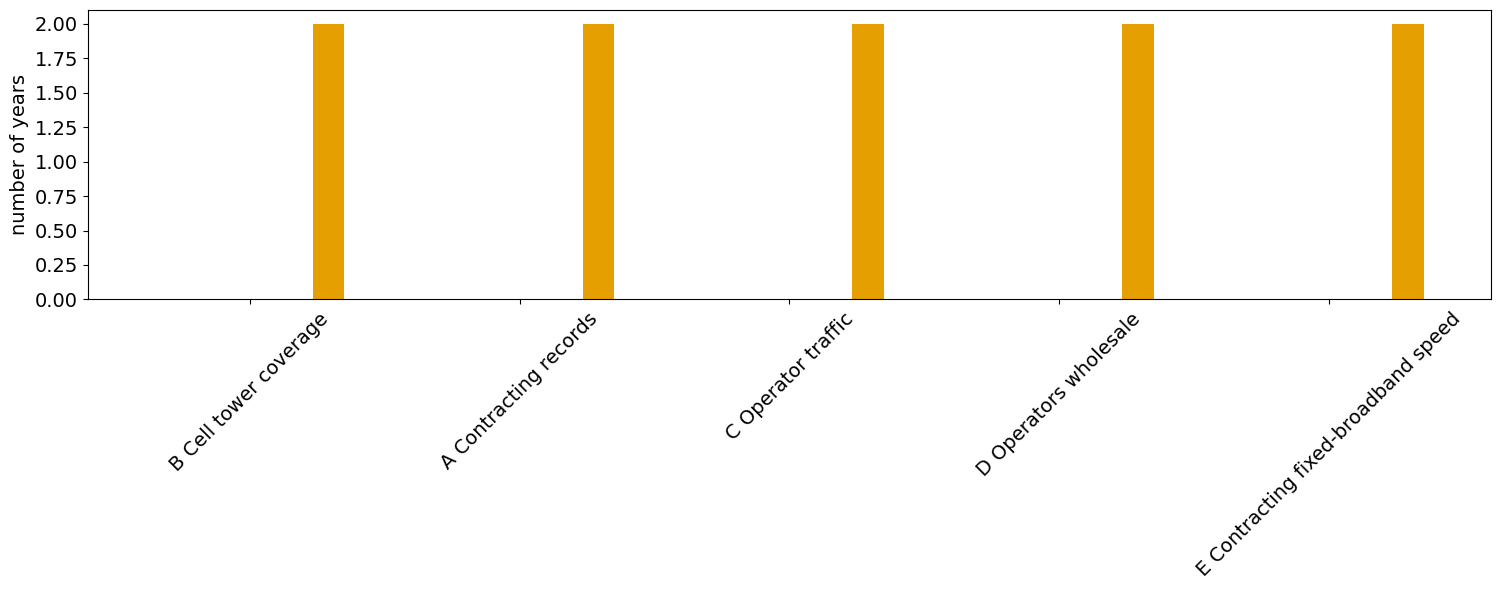

In [116]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]

rename_dict = {
'B. Cell_tower_coverage_timeliness': "B Cell tower coverage",
'A. Contracting_records_timeliness':"A Contracting records",
'C. Operator_traffic_timeliness':"C Operator traffic",
'D. Operators_wholesale_timeliness':"D Operators wholesale",
'E. Contracting_fixed_broadband_speed_timeliness': "E Contracting fixed-broadband speed"
}

pivoted_t_group[pivoted_t_group.ShortName=='Madagascar'][['RegionName','B. Cell_tower_coverage_timeliness',
       'A. Contracting_records_timeliness', 'C. Operator_traffic_timeliness',
       'D. Operators_wholesale_timeliness', 'E. Contracting_fixed_broadband_speed_timeliness']].rename(
     columns=rename_dict).groupby('RegionName').mean(numeric_only=True).reindex(custom_order).T.sort_values(by='Africa', ascending=True).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  color=custom_colors,
                                                  width=0.7)
#plt.title('Timeliness in 2025: time lag of latest available data point in number of years (available data only)')
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# adjust bottom margin to make space for legend
plt.subplots_adjust(bottom=0.6)  # increase bottom space

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -1.1),
    ncol=7,
    fontsize=12
)
plt.legend().remove()

plt.tight_layout()
plt.show()

## Comparing availability to timeliness

In [117]:
merged = pd.merge(pivoted[['ShortName', 'RegionName', 'IsoCode', 'new_group', 'CountryType',
       'WB_Income','availability_5Y']], pivoted_t[['IsoCode', 'timeliness']], on='IsoCode', how='left')

merged.ShortName.nunique()

184

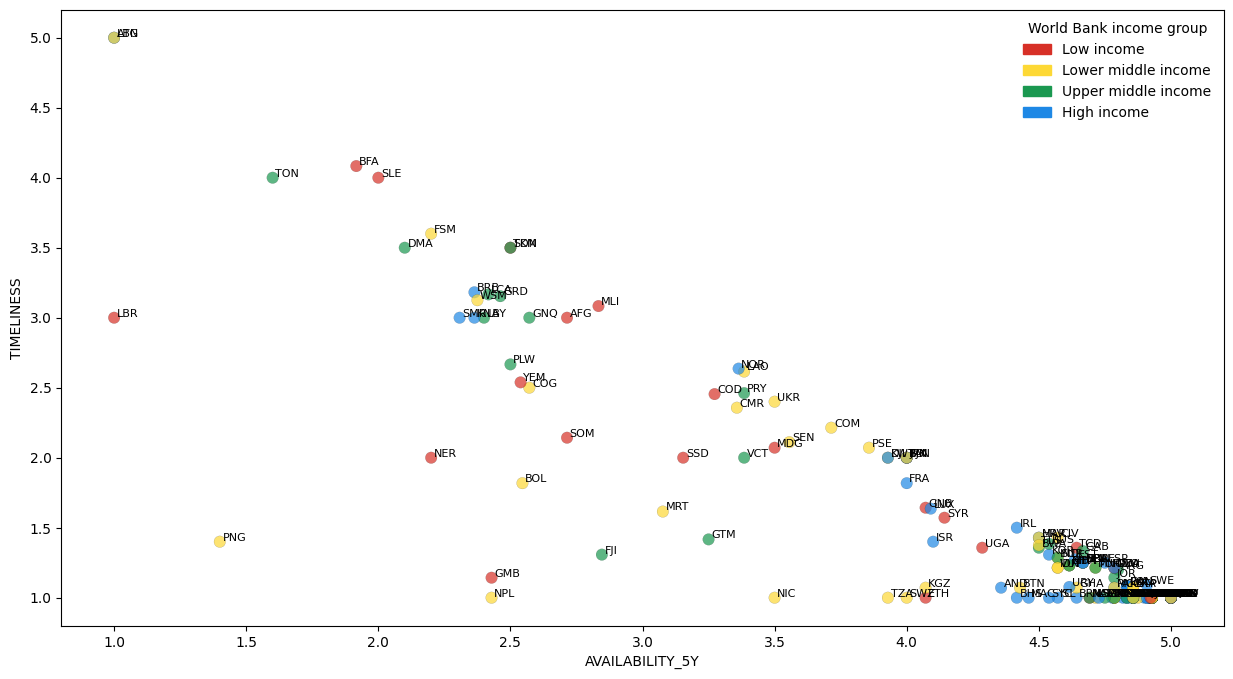

In [118]:
import matplotlib.patches as mpatches

# Start plotting
plt.figure(figsize=(15, 8))

# Assign a color to each income group
group_colors = {
    #'n.a.': '#999999',
    'Low income': '#d73027',
    'Lower middle income': '#fdd835',
    'Upper middle income': '#1a9850',
    'High income': '#1e88e5'
}
merged['group_color'] = merged['WB_Income'].map(group_colors)

# Define your columns
x_column = 'availability_5Y'
y_column = 'timeliness'
label_column='IsoCode'

# Scatter plot with manually assigned colors
plt.scatter(
    merged[x_column], merged[y_column],
    c=merged['group_color'],
    s=70, edgecolors='k', linewidths=0.1, alpha=0.7
)

# Add point labels
for i, label in enumerate(merged[label_column]):
    plt.text(merged[x_column].iloc[i]+0.01, merged[y_column].iloc[i]+0.01, label, fontsize=8)


# Add axis labels and title
plt.xlabel(x_column.upper())
plt.ylabel(y_column.upper())


# Add legend
patches = [mpatches.Patch(color=color, label=label) for label, color in group_colors.items()]
plt.legend(handles=patches, title='World Bank income group', frameon=False)

plt.show()

Sanity check 1: all countries that have 100% availability, have timeliness

In [119]:
merged [merged.availability_5Y==5]

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,availability_5Y,timeliness,group_color
8,Australia,Asia & Pacific,AUS,Developed-OECD,Developed,High income,5.0,1.0,#1e88e5
10,Azerbaijan,CIS countries,AZE,Other developing and transition,Developing,Upper middle income,5.0,1.0,#1a9850
12,Bahrain,Arab States,BHR,Other developing and transition,Developing,High income,5.0,1.0,#1e88e5
37,Costa Rica,The Americas,CRI,Developed-OECD,Developing,Upper middle income,5.0,1.0,#1a9850
41,Czech Republic,Europe countries,CZE,Developed-OECD,Developed,High income,5.0,1.0,#1e88e5
44,Denmark,Europe countries,DNK,Developed-OECD,Developed,High income,5.0,1.0,#1e88e5
67,Honduras,The Americas,HND,Other developing and transition,Developing,Lower middle income,5.0,1.0,#fdd835
68,"Hong Kong, China",Asia & Pacific,HKG,Other developing and transition,Developing,High income,5.0,1.0,#1e88e5
73,Iran (Islamic Republic of),Asia & Pacific,IRN,Other developing and transition,Developing,Lower middle income,5.0,1.0,#fdd835
93,Liechtenstein,Europe countries,LIE,Other developing and transition,Developed,High income,5.0,1.0,#1e88e5


In [120]:
# list of developing, transition and SIDS+LDC who do well

merged[(merged.timeliness<1.5) & (merged.availability_5Y>=4.9) & (merged['new_group'].isin(['Other developing and transition', 'SIDS + LDC']))].sort_values(by='ShortName', ascending=True)

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,availability_5Y,timeliness,group_color
1,Albania,Europe countries,ALB,Other developing and transition,Developed,Upper middle income,4.923077,1.0,#1a9850
7,Armenia,CIS countries,ARM,Other developing and transition,Developing,Upper middle income,4.928571,1.0,#1a9850
10,Azerbaijan,CIS countries,AZE,Other developing and transition,Developing,Upper middle income,5.000000,1.0,#1a9850
12,Bahrain,Arab States,BHR,Other developing and transition,Developing,High income,5.000000,1.0,#1e88e5
13,Bangladesh,Asia & Pacific,BGD,SIDS + LDC,Developing,Lower middle income,4.928571,1.0,#fdd835
22,Brazil,The Americas,BRA,Other developing and transition,Developing,Upper middle income,4.916667,1.0,#1a9850
24,Bulgaria,Europe countries,BGR,Other developing and transition,Developed,Upper middle income,4.928571,1.0,#1a9850
33,China,Asia & Pacific,CHN,Other developing and transition,Developing,Upper middle income,4.928571,1.0,#1a9850
39,Cuba,The Americas,CUB,SIDS + LDC,Developing,Upper middle income,4.928571,1.0,#1a9850
40,Cyprus,Europe countries,CYP,Other developing and transition,Developed,High income,4.928571,1.0,#1e88e5


In [121]:
# countries that could be considered of priority for capacity building
merged [(merged.timeliness>=2) & (merged.availability_5Y<4)].sort_values(by='IsoCode', ascending=True)

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,availability_5Y,timeliness,group_color
0,Afghanistan,Asia & Pacific,AFG,SIDS + LDC,Developing,Low income,2.714286,3.000000,#d73027
5,Antigua and Barbuda,The Americas,ATG,SIDS + LDC,Developing,High income,1.000000,5.000000,#1e88e5
25,Burkina Faso,Africa,BFA,SIDS + LDC,Developing,Low income,1.916667,4.083333,#d73027
14,Barbados,The Americas,BRB,SIDS + LDC,Developing,High income,2.363636,3.181818,#1e88e5
29,Cameroon,Africa,CMR,Other developing and transition,Developing,Lower middle income,3.357143,2.357143,#fdd835
43,Dem. Rep. of the Congo,Africa,COD,SIDS + LDC,Developing,Low income,3.272727,2.454545,#d73027
36,Congo (Rep. of the),Africa,COG,Other developing and transition,Developing,Lower middle income,2.571429,2.500000,#fdd835
35,Comoros,Arab States,COM,SIDS + LDC,Developing,Lower middle income,3.714286,2.214286,#fdd835
45,Djibouti,Arab States,DJI,SIDS + LDC,Developing,Lower middle income,3.928571,2.000000,#fdd835
46,Dominica,The Americas,DMA,SIDS + LDC,Developing,Upper middle income,2.100000,3.500000,#1a9850


In [122]:
!pip install pycountry
import pycountry

# Create a dictionary mapping ISO3 to ISO2 codes
iso3_to_iso2 = {country.alpha_3: country.alpha_2 for country in pycountry.countries}

# Map the ISO3 codes to ISO2 codes
merged['iso2'] = merged['IsoCode'].map(iso3_to_iso2)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 84.8 MB/s eta 0:00:00


116 [-0.13309181 -0.53856868]
176 [-0.60974074 -0.48006775]
39 [ 0.85017165 -0.6971082 ]
99 [-0.58480809  0.77294914]
13 [-0.8483618  -0.94412864]
33 [-0.26400036  0.82441654]
7 [-0.71405387 -0.95022441]
110 [-0.83786841 -0.56601082]
10 [-0.11779014  0.38439   ]
133 [0.11638974 0.92943657]
41 [ 0.21439171 -0.52095675]
174 [-0.78103712  0.32202381]
160 [-0.18941917 -0.95741149]
178 [-0.07585099  0.54771283]
44 [-0.40074918  0.99774934]
166 [-0.75919015  0.94791516]


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



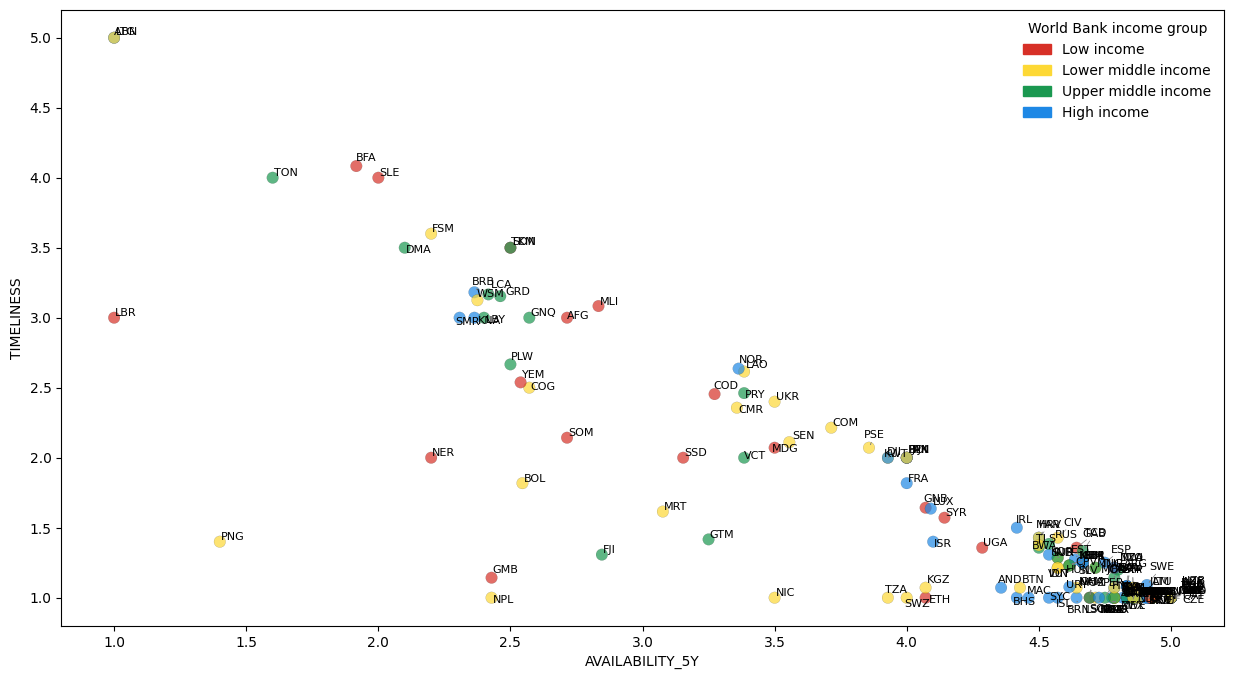

In [123]:
import matplotlib.patches as mpatches

# Start plotting
plt.figure(figsize=(15, 8))

# Assign a color to each income group
group_colors = {
    #'n.a.': '#999999',
    'Low income': '#d73027',
    'Lower middle income': '#fdd835',
    'Upper middle income': '#1a9850',
    'High income': '#1e88e5'
}
merged['group_color'] = merged['WB_Income'].map(group_colors)

# Define your columns
x_column = 'availability_5Y'
y_column = 'timeliness'
label_column='iso2'

# Scatter plot with manually assigned colors
plt.scatter(
    merged[x_column], merged[y_column],
    c=merged['group_color'],
    s=70, edgecolors='k', linewidths=0.1, alpha=0.7
)

# Add point labels
#for i, label in enumerate(merged[label_column]):
    #plt.text(merged[x_column].iloc[i]+0.01, merged[y_column].iloc[i]+0.01, label, fontsize=8)

# Create text objects
texts = []
for i, row in merged.iterrows():
    texts.append(
        plt.text(row['availability_5Y'],
                 row['timeliness'],
                 row['IsoCode'],
                 fontsize=8)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))


# Add axis labels and title
plt.xlabel(x_column.upper())
plt.ylabel(y_column.upper())


# Add legend
patches = [mpatches.Patch(color=color, label=label) for label, color in group_colors.items()]
plt.legend(handles=patches, title='World Bank income group', frameon=False)

plt.show()

Do this again, but for those with availability below 4

In [124]:
merged[merged.availability_5Y<4].sort_values(by='IsoCode', ascending=True)

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,availability_5Y,timeliness,group_color,iso2
0,Afghanistan,Asia & Pacific,AFG,SIDS + LDC,Developing,Low income,2.714286,3.000000,#d73027,AF
5,Antigua and Barbuda,The Americas,ATG,SIDS + LDC,Developing,High income,1.000000,5.000000,#1e88e5,AG
25,Burkina Faso,Africa,BFA,SIDS + LDC,Developing,Low income,1.916667,4.083333,#d73027,BF
19,Bolivia (Plurinational State of),The Americas,BOL,Other developing and transition,Developing,Lower middle income,2.545455,1.818182,#fdd835,BO
14,Barbados,The Americas,BRB,SIDS + LDC,Developing,High income,2.363636,3.181818,#1e88e5,BB
29,Cameroon,Africa,CMR,Other developing and transition,Developing,Lower middle income,3.357143,2.357143,#fdd835,CM
43,Dem. Rep. of the Congo,Africa,COD,SIDS + LDC,Developing,Low income,3.272727,2.454545,#d73027,CD
36,Congo (Rep. of the),Africa,COG,Other developing and transition,Developing,Lower middle income,2.571429,2.500000,#fdd835,CG
35,Comoros,Arab States,COM,SIDS + LDC,Developing,Lower middle income,3.714286,2.214286,#fdd835,KM
45,Djibouti,Arab States,DJI,SIDS + LDC,Developing,Lower middle income,3.928571,2.000000,#fdd835,DJ


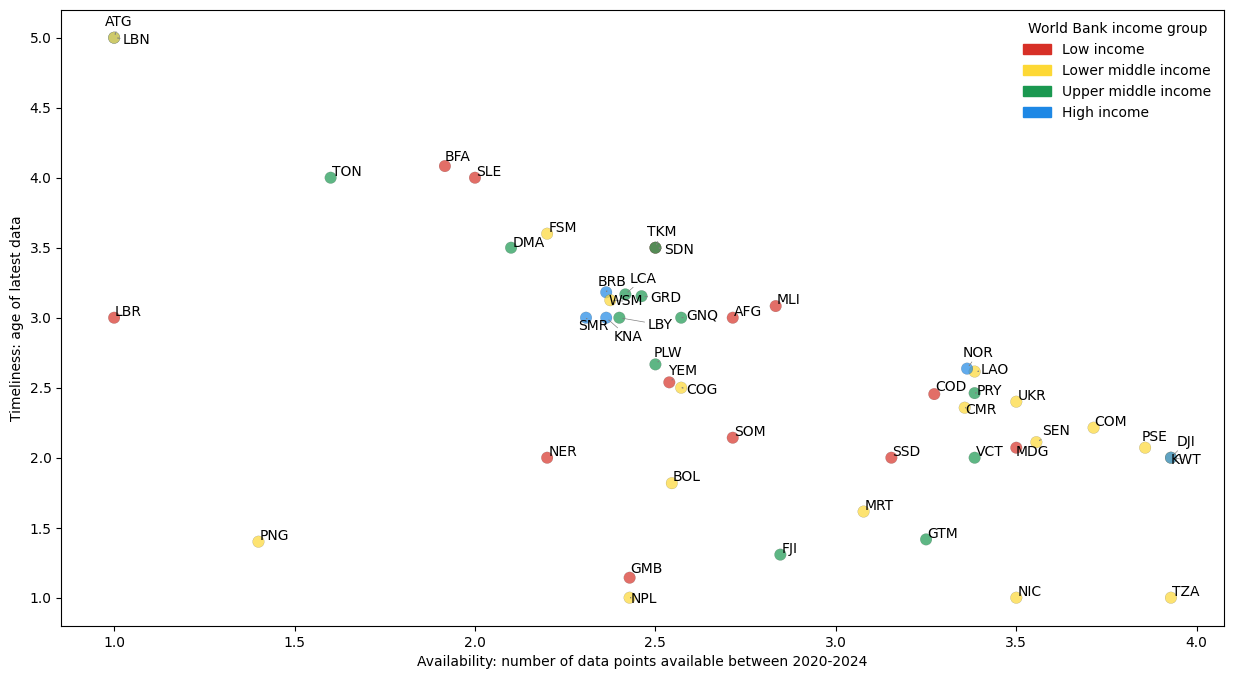

In [125]:
import matplotlib.patches as mpatches

# Start plotting
plt.figure(figsize=(15, 8))

# Assign a color to each income group
group_colors = {
    #'n.a.': '#999999',
    'Low income': '#d73027',
    'Lower middle income': '#fdd835',
    'Upper middle income': '#1a9850',
    'High income': '#1e88e5'
}
merged['group_color'] = merged['WB_Income'].map(group_colors)

# Define your columns
x_column = 'availability_5Y'
y_column = 'timeliness'
label_column='iso2'

# Scatter plot with manually assigned colors
plt.scatter(
    merged[merged.availability_5Y<4][x_column], merged[merged.availability_5Y<4][y_column],
    c=merged[merged.availability_5Y<4]['group_color'],
    s=70, edgecolors='k', linewidths=0.1, alpha=0.7
)

# Add point labels
#for i, label in enumerate(merged[label_column]):
    #plt.text(merged[x_column].iloc[i]+0.01, merged[y_column].iloc[i]+0.01, label, fontsize=8)

# Create text objects
texts = []
for i, row in merged[merged.availability_5Y<4].iterrows():
    texts.append(
        plt.text(row['availability_5Y'],
                 row['timeliness'],
                 row['IsoCode'],
                 fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))


# Add axis labels and title
plt.xlabel('Availability: number of data points available between 2020-2024')
plt.ylabel('Timeliness: age of latest data')


# Add legend
patches = [mpatches.Patch(color=color, label=label) for label, color in group_colors.items()]
plt.legend(handles=patches, title='World Bank income group', frameon=False)

plt.show()

## Group-wise find priority countries for assistance

By indicator group, find countries that have unsatisfactory timeliness and low availability by group of indicators

In [126]:
merged_group = pd.merge(pivoted_group[['ShortName', 'RegionName', 'IsoCode', 'new_group', 'CountryType',
       'WB_Income', 'A. Contracting_records_5Y', 'B. Cell_tower_coverage_5Y',
       'C. Operator_traffic_5Y', 'D. Operators_wholesale_5Y',
       'E. Contracting_fixed_broadband_speed_5Y',]], pivoted_t_group[['IsoCode', 'A. Contracting_records_timeliness',
       'B. Cell_tower_coverage_timeliness', 'C. Operator_traffic_timeliness',
       'D. Operators_wholesale_timeliness',
       'E. Contracting_fixed_broadband_speed_timeliness']],
        on='IsoCode', how='left')

merged_group.ShortName.nunique()

184

In [127]:
# now checking for cell tower coverage indicators

merged_group[['ShortName', 'RegionName', 'IsoCode', 'new_group', 'CountryType',
       'WB_Income', 'B. Cell_tower_coverage_5Y', 'B. Cell_tower_coverage_timeliness']][(merged_group['B. Cell_tower_coverage_5Y']<3) & (merged_group['B. Cell_tower_coverage_timeliness']>1)].sort_values(by='ShortName', ascending=True)

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,B. Cell_tower_coverage_5Y,B. Cell_tower_coverage_timeliness
5,Antigua and Barbuda,The Americas,ATG,SIDS + LDC,Developing,High income,1.0,5.0
25,Burkina Faso,Africa,BFA,SIDS + LDC,Developing,Low income,2.0,4.0
29,Cameroon,Africa,CMR,Other developing and transition,Developing,Lower middle income,2.0,3.0
46,Dominica,The Americas,DMA,SIDS + LDC,Developing,Upper middle income,2.0,3.0
89,Lebanon,Arab States,LBN,Other developing and transition,Developing,Lower middle income,1.0,5.0
91,Liberia,Africa,LBR,SIDS + LDC,Developing,Low income,1.0,3.0
138,Saint Lucia,The Americas,LCA,SIDS + LDC,Developing,Upper middle income,2.0,3.0
147,Sierra Leone,Africa,SLE,SIDS + LDC,Developing,Low income,2.0,4.0
167,Tonga,Asia & Pacific,TON,SIDS + LDC,Developing,Upper middle income,2.0,4.0


In [128]:
# now checking for Contracting_fixed_broadband_speed


merged_group[['ShortName', 'RegionName', 'IsoCode', 'new_group', 'CountryType',
       'WB_Income', 'E. Contracting_fixed_broadband_speed_5Y', 'E. Contracting_fixed_broadband_speed_timeliness']][(merged_group['E. Contracting_fixed_broadband_speed_5Y']<3) & (merged_group['E. Contracting_fixed_broadband_speed_timeliness']>1)].sort_values(by='ShortName', ascending=True)

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,E. Contracting_fixed_broadband_speed_5Y,E. Contracting_fixed_broadband_speed_timeliness
0,Afghanistan,Asia & Pacific,AFG,SIDS + LDC,Developing,Low income,1.0,5.0
14,Barbados,The Americas,BRB,SIDS + LDC,Developing,High income,2.0,3.0
19,Bolivia (Plurinational State of),The Americas,BOL,Other developing and transition,Developing,Lower middle income,2.0,4.0
25,Burkina Faso,Africa,BFA,SIDS + LDC,Developing,Low income,2.0,4.0
36,Congo (Rep. of the),Africa,COG,Other developing and transition,Developing,Lower middle income,2.0,2.0
46,Dominica,The Americas,DMA,SIDS + LDC,Developing,Upper middle income,2.0,3.0
51,Equatorial Guinea,Africa,GNQ,Other developing and transition,Developing,Upper middle income,2.0,3.0
89,Lebanon,Arab States,LBN,Other developing and transition,Developing,Lower middle income,1.0,5.0
92,Libya,Arab States,LBY,Other developing and transition,Developing,Upper middle income,2.0,3.0
125,Palau,Asia & Pacific,PLW,SIDS + LDC,Developing,Upper middle income,2.0,2.0


In [129]:
# now checking for Contracting_records



merged_group[['ShortName', 'RegionName', 'IsoCode', 'new_group', 'CountryType',
       'WB_Income', 'A. Contracting_records_5Y', 'A. Contracting_records_timeliness']][(merged_group['A. Contracting_records_5Y']<3) & (merged_group['A. Contracting_records_timeliness']>1)].sort_values(by='ShortName', ascending=True)

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,A. Contracting_records_5Y,A. Contracting_records_timeliness
5,Antigua and Barbuda,The Americas,ATG,SIDS + LDC,Developing,High income,1.0,5.0
25,Burkina Faso,Africa,BFA,SIDS + LDC,Developing,Low income,2.0,4.0
89,Lebanon,Arab States,LBN,Other developing and transition,Developing,Lower middle income,1.0,5.0
91,Liberia,Africa,LBR,SIDS + LDC,Developing,Low income,1.0,3.0
106,Micronesia,Asia & Pacific,FSM,SIDS + LDC,Developing,Lower middle income,2.0,4.0
147,Sierra Leone,Africa,SLE,SIDS + LDC,Developing,Low income,2.0,4.0
167,Tonga,Asia & Pacific,TON,SIDS + LDC,Developing,Upper middle income,2.0,4.0


In [130]:
# now checking for Operator_traffic



merged_group[['ShortName', 'RegionName', 'IsoCode', 'new_group', 'CountryType',
       'WB_Income', 'C. Operator_traffic_5Y', 'C. Operator_traffic_timeliness']][(merged_group['C. Operator_traffic_5Y']<3) & (merged_group['C. Operator_traffic_timeliness']>1)].sort_values(by='ShortName', ascending=True)

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,C. Operator_traffic_5Y,C. Operator_traffic_timeliness
14,Barbados,The Americas,BRB,SIDS + LDC,Developing,High income,1.0,4.0
25,Burkina Faso,Africa,BFA,SIDS + LDC,Developing,Low income,2.0,4.0
46,Dominica,The Americas,DMA,SIDS + LDC,Developing,Upper middle income,1.0,5.0
58,Gabon,Africa,GAB,Other developing and transition,Developing,Upper middle income,1.0,5.0
59,Gambia,Africa,GMB,SIDS + LDC,Developing,Low income,2.0,2.0
64,Grenada,The Americas,GRD,SIDS + LDC,Developing,Upper middle income,1.0,5.0
87,Lao P.D.R.,Asia & Pacific,LAO,SIDS + LDC,Developing,Lower middle income,2.0,4.0
89,Lebanon,Arab States,LBN,Other developing and transition,Developing,Lower middle income,1.0,5.0
91,Liberia,Africa,LBR,SIDS + LDC,Developing,Low income,1.0,3.0
128,Paraguay,The Americas,PRY,Other developing and transition,Developing,Upper middle income,1.0,5.0


In [131]:
# now checking for Operators_wholesale


merged_group[['ShortName', 'RegionName', 'IsoCode', 'new_group', 'CountryType',
       'WB_Income', 'D. Operators_wholesale_5Y', 'D. Operators_wholesale_timeliness']][(merged_group['D. Operators_wholesale_5Y']<3) & (merged_group['D. Operators_wholesale_timeliness']>1)].sort_values(by='ShortName', ascending=True)

,ShortName,RegionName,IsoCode,new_group,CountryType,WB_Income,D. Operators_wholesale_5Y,D. Operators_wholesale_timeliness
14,Barbados,The Americas,BRB,SIDS + LDC,Developing,High income,1.0,4.0
19,Bolivia (Plurinational State of),The Americas,BOL,Other developing and transition,Developing,Lower middle income,2.0,4.0
25,Burkina Faso,Africa,BFA,SIDS + LDC,Developing,Low income,2.0,4.0
36,Congo (Rep. of the),Africa,COG,Other developing and transition,Developing,Lower middle income,2.0,2.0
87,Lao P.D.R.,Asia & Pacific,LAO,SIDS + LDC,Developing,Lower middle income,2.0,4.0
89,Lebanon,Arab States,LBN,Other developing and transition,Developing,Lower middle income,1.0,5.0
101,Mali,Africa,MLI,SIDS + LDC,Developing,Low income,2.0,3.0
137,Saint Kitts and Nevis,The Americas,KNA,SIDS + LDC,Developing,High income,1.0,4.0
139,Saint Vincent and the Grenadines,The Americas,VCT,SIDS + LDC,Developing,Upper middle income,1.0,5.0
140,Samoa,Asia & Pacific,WSM,SIDS + LDC,Developing,Lower middle income,1.0,3.0
